## Imports

In [84]:
import os
import glob
import pickle
import base64

from tqdm import tqdm

from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as display, HTML

from google.colab import files, drive

import matplotlib.pyplot as plt

import numpy as np

from scipy.ndimage import zoom
from scipy.linalg import sqrtm

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import ops
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.random import SeedGenerator, normal
from tensorflow.keras.metrics import Mean
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

## Model config



In [125]:
MODEL_CONFIG = {
    'model_name': 'afgan',
    'dataset_path': '/content/data/images',
    'latent_dim': 100,
    'image_size': (64, 64),
    'hyperparam': {
        'adam': {
            'lr_d': 0.0001,
            'lr_g': 0.0003,
            'b1': 0.5,
            'b2': 0.999,
        },
        'leakyrelu_alpha': 0.2,
        'dropout_rate_d': 0.1,
        'changing_label_smoothing': {
            'real_value': 0.9,
            'fake_value': 0.1
        },
        'noise_std': 0.1,
        # 'noise_annealing': {
        #     'initial_std': 0.1,
        #     'final_std': 0.0,
        #     'end_epoch_ratio': 0.85
        # }
    },
    'train': {
        'batch_size': 64,
        'epochs': 15,
        'initial_epoch': 0,
        'checkpoint': {
            'dir': '/content/drive/MyDrive/models/afgan/checkpoints',
            'save_freq': 10,
            'max_to_keep': 3,
            'restore': False
        },
        'num_image_eval': 5,
        'fid': {
            'eval_freq': 15,
            'num_samples': 50
        }
    },
    'ei': {
        'weight': {
            'd': {
                'path': '/content/{model_name}-discriminator.weights.h5',
                'import': False,
                'export': False
            },
            'g': {
                'path': '/content/{model_name}-generator.weights.h5',
                'import': False,
                'export': True
            },
        },
        'model': {
            'd': {
                'path': '/content/{model_name}-discriminator.keras',
                'import': False,
                'export': False
            },
            'g': {
                'path': '/content/{model_name}-generator.keras',
                'import': False,
                'export': True
            },
        },
    },
    'seed': 74134,
    'test': {
        'num_images': 25,
    },
    'result': {
        'num_images': 200,
        'grid_path': '/content/{model_name}-grid.png',
        'grid_gif_path': '/content/{model_name}-grid.gif',
    },
    'model_evaluation': {
        'iterations': 3,
        'num_samples': 500
    }
}

## Dataset


### Download


In [86]:
!rm -rf ./data sample_data

os.environ['KAGGLE_USERNAME'] = ''
os.environ['KAGGLE_KEY'] = ''

!kaggle datasets download splcher/animefacedataset

!unzip -q animefacedataset.zip -d ./data

!rm -rf animefacedataset.zip

Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset
License(s): DbCL-1.0
 97% 384M/395M [00:01<00:00, 255MB/s]
100% 395M/395M [00:01<00:00, 337MB/s]


### Load dataset

We know that the images are between 90 * 90px ~ 120 * 120px in RGB.

In [87]:
print(f"Dataset size: {len(os.listdir(MODEL_CONFIG['dataset_path']))} images")

Dataset size: 63565 images


In [88]:
train_dataset = image_dataset_from_directory(
    MODEL_CONFIG['dataset_path'],
    labels=None,
    color_mode="rgb",
    batch_size=MODEL_CONFIG['train']['batch_size'],
    image_size=MODEL_CONFIG['image_size'],
    shuffle=True,
    seed=MODEL_CONFIG['seed'],
)

Found 63565 files.


Normalizar datos entre [-1, 1]

In [89]:
train_dataset = train_dataset.map(lambda x: (x / 127.5) - 1)

Data augmentation

In [90]:
layer_data_augmentation = Sequential([
    layers.RandomFlip("horizontal", name="horizontal_flip")
], trainable=False, name='data_augmentation')

Vemos algunos imagenes

In [91]:
def show_dataset(dataset, max_images=5):
    images = next(iter(dataset.take(1)))
    images = images.numpy()

    n = min(max_images, len(images))

    cols = 5
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))

    if rows * cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i in range(n):
        img_display = (images[i] + 1) / 2.0

        axes[i].imshow(img_display)
        height, width = images[i].shape[:2]
        axes[i].set_title(f'Image {i+1}\n{width}x{height}', fontweight='bold')
        axes[i].axis('off')

    for i in range(n, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

Training images


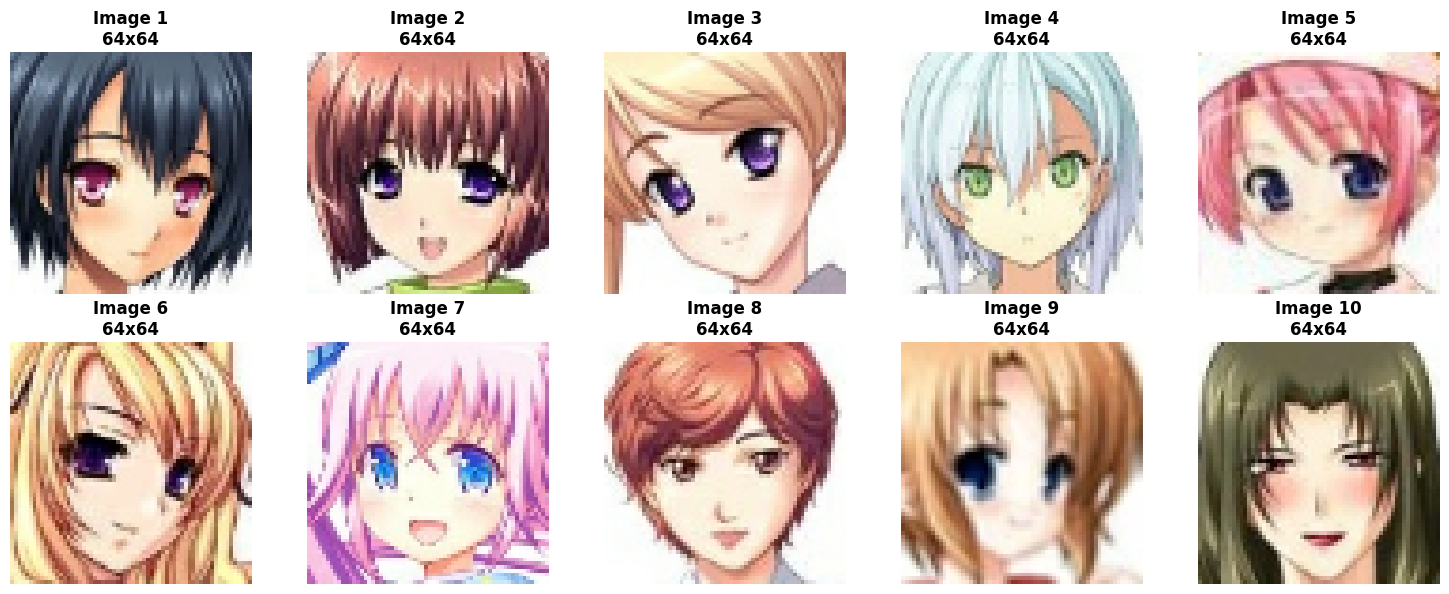

In [92]:
print("Training images")
show_dataset(train_dataset, 10)

## Evaluation

FID evaluator

In [93]:
class FIDEvaluator:
    def __init__(self):
        self.model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    def preprocess_images(self, images):
        if images.shape[-1] == 1:
            images = tf.repeat(images, 3, axis=-1)

        images = (images + 1.0) / 2.0
        images = tf.image.resize(images, (299, 299))
        images = preprocess_input(images * 255.0)

        return images

    def get_activations(self, images, batch_size=32):
        images = self.preprocess_images(images)

        activations = []
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size]
            act = self.model.predict(batch, verbose=0)
            activations.append(act)

        return np.concatenate(activations, axis=0)

    def calculate_fid(self, real_images, generated_images):
        act_real = self.get_activations(real_images)
        act_gen = self.get_activations(generated_images)

        mu_real = np.mean(act_real, axis=0)
        sigma_real = np.cov(act_real, rowvar=False)

        mu_gen = np.mean(act_gen, axis=0)
        sigma_gen = np.cov(act_gen, rowvar=False)

        diff = mu_real - mu_gen
        covmean = sqrtm(sigma_real @ sigma_gen)

        if np.iscomplexobj(covmean):
            covmean = covmean.real

        fid = diff @ diff + np.trace(sigma_real + sigma_gen - 2 * covmean)

        return fid

In [94]:
def evaluate_gan(generator, real_dataset, latent_dim, num_samples, batch_size=128):
    if num_samples < batch_size:
        raise ValueError(f"Number of samples must be greater than or equal to batch size {batch_size}: {num_samples}")

    fid_calc = FIDEvaluator()

    real_images = []
    num_batches = (num_samples + batch_size - 1) // batch_size
    for images in real_dataset.take(num_batches):
        real_images.append(images.numpy())
    real_images = np.concatenate(real_images, axis=0)[:num_samples]

    generated_images = []
    for i in range(0, num_samples, batch_size):
        current_batch_size = min(batch_size, num_samples - i)
        noise = tf.random.normal([current_batch_size, latent_dim])
        gen_imgs = generator(noise, training=False)
        generated_images.append(gen_imgs.numpy())
    generated_images = np.concatenate(generated_images, axis=0)[:num_samples]

    fid_score = fid_calc.calculate_fid(real_images, generated_images)

    return fid_score

In [95]:
def evaluate_gan_multiple_iterations(generator, real_dataset, latent_dim, num_samples, iterations=33):
    fid_scores = []

    for i in tqdm(range(iterations), desc="Model evaluate"):
        fid_score = evaluate_gan(
            generator=generator,
            real_dataset=real_dataset,
            latent_dim=latent_dim,
            num_samples=num_samples
        )
        fid_scores.append(fid_score)

    return np.array(fid_scores)

In [96]:
def plot_evaluate_result(fid_scores):
  fid_mean = np.mean(fid_scores)
  fid_std = np.std(fid_scores)
  fid_min = np.min(fid_scores)
  fid_max = np.max(fid_scores)
  fid_median = np.median(fid_scores)

  # Create visualizations
  fig, axes = plt.subplots(1, 3, figsize=(15, 4))

  # Plot 1: FID score evolution per iteration
  axes[0].plot(range(1, len(fid_scores) + 1), fid_scores, 'b-', alpha=0.7, linewidth=1.5)
  axes[0].axhline(y=fid_mean, color='r', linestyle='--', label=f'Mean: {fid_mean:.2f}')
  axes[0].axhline(y=fid_median, color='g', linestyle='--', label=f'Median: {fid_median:.2f}')
  axes[0].set_xlabel('Iteration')
  axes[0].set_ylabel('FID Score')
  axes[0].set_title(f'FID Score Evolution\n{MODEL_CONFIG["model_name"]}')
  axes[0].grid(True, alpha=0.3)
  axes[0].legend()

  # Plot 2: Distribution histogram
  axes[1].hist(fid_scores, bins=15, color='skyblue', edgecolor='black', alpha=0.7)
  axes[1].axvline(x=fid_mean, color='r', linestyle='--', label=f'Mean: {fid_mean:.2f}')
  axes[1].axvline(x=fid_median, color='g', linestyle='--', label=f'Median: {fid_median:.2f}')
  axes[1].set_xlabel('FID Score')
  axes[1].set_ylabel('Frequency')
  axes[1].set_title(f'FID Score Distribution\n({MODEL_CONFIG["model_evaluation"]["iterations"]} iterations)')
  axes[1].grid(True, alpha=0.3)
  axes[1].legend()

  # Plot 3: Boxplot
  bp = axes[2].boxplot(fid_scores, vert=True, patch_artist=True)
  bp['boxes'][0].set_facecolor('lightblue')
  bp['medians'][0].set_color('red')
  axes[2].set_ylabel('FID Score')
  axes[2].set_title(f'FID Score Boxplot\nσ = {fid_std:.2f}')
  axes[2].grid(True, alpha=0.3)

  # Add statistics text in the boxplot
  stats_text = f'μ = {fid_mean:.2f}\nσ = {fid_std:.2f}\nMin = {fid_min:.2f}\nMax = {fid_max:.2f}'
  axes[2].text(1.15, fid_mean, stats_text, fontsize=10,
              bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

  plt.suptitle(f'FID Evaluation Analysis - {MODEL_CONFIG["model_name"]}',
              fontsize=14, fontweight='bold', y=1.05)
  plt.tight_layout()
  plt.show()


Callback

In [97]:
class FIDEvaluateCallback(keras.callbacks.Callback):
    def __init__(self, generator, real_dataset, latent_dim, eval_freq, num_samples, batch_size=32):
        super().__init__()
        self.generator = generator
        self.real_dataset = real_dataset
        self.latent_dim = latent_dim
        self.eval_freq = eval_freq
        self.num_samples = num_samples
        self.fid_calculator = FIDEvaluator()
        self.fid_history = []

        if num_samples < batch_size:
            raise ValueError(f"Number of samples must be greater than batch size {batch_size}: {num_samples}")

        real_images = []
        num_batches = (num_samples + batch_size - 1) // batch_size
        for images in real_dataset.take(num_batches):
            real_images.append(images.numpy())
        self.real_images = np.concatenate(real_images, axis=0)[:num_samples]

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.eval_freq == 0:
            noise = tf.random.normal([self.num_samples, self.latent_dim])
            generated_images = self.generator(noise, training=False).numpy()

            fid_score = self.fid_calculator.calculate_fid(self.real_images, generated_images)

            self.fid_history.append((epoch + 1, fid_score))

            print(f"\nEpoch {epoch + 1} - FID: {fid_score:.2f}")

In [98]:
def show_fid_history(fid_history):
    if len(fid_history) == 0:
        print("No FID score history data available to display")
        return

    epochs = [x[0] for x in fid_history]
    fid_scores = [x[1] for x in fid_history]

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, fid_scores, marker='o', linewidth=2, markersize=8)
    plt.xlabel('Epoch', fontsize=12, fontweight='bold')
    plt.ylabel('FID Score', fontsize=12, fontweight='bold')
    plt.title('FID Score Evolution During Training', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

    min_fid = min(fid_scores)
    min_epoch = epochs[fid_scores.index(min_fid)]
    plt.axhline(y=min_fid, linestyle='--', alpha=0.5, label=f'Best FID: {min_fid:.2f} (Epoch {min_epoch})')

    plt.legend()
    plt.tight_layout()
    plt.show()

## Model

### Generator

In [99]:
generator = None

In [100]:
def create_generator_model(latent_dim):
    input = layers.Input(shape=(latent_dim,))

    # 4x4x512
    x = layers.Dense(4 * 4 * 512, use_bias=True)(input)
    x = layers.ReLU()(x)
    x = layers.Reshape((4, 4, 512))(x)

    # 4x4 -> 8x8
    x = layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 8x8 -> 16x16
    x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 16x16 -> 32x32
    x = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 32x32 -> 64x64
    x = layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 64x64x16 -> 64x64x3
    output = layers.Conv2DTranspose(3, (3, 3), padding='same', activation='tanh')(x)

    return Model(input, output, name=f"generator-{MODEL_CONFIG['model_name']}")

In [101]:
if(MODEL_CONFIG['ei']['model']['g']['import']):
  generator = keras.models.load_model(MODEL_CONFIG['ei']['model']['g']['path'].format(model_name=MODEL_CONFIG['model_name']))
else:
  generator = create_generator_model(MODEL_CONFIG['latent_dim'])

generator.summary()

Model: "generator-afgan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8192)           │       827,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 8, 8, 256)      │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_110         │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 16, 16, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_111         │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 32, 32, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_112         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_13             │ (None, 64, 64, 32)     │        32,768 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_113         │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_14             │ (None, 64, 64, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,615,459 (13.79 MB)

 Trainable params: 3,614,499 (13.79 MB)

 Non-trainable params: 960 (3.75 KB)

### Discriminator

#### Regularization

#### Changed Label Smoothing

Inspeared by [article](https://www.iieta.org/download/file/fid/129808).

In [102]:
class ChangedLabelSmoothing(tf.Module):
    def __init__(self, real_start, fake_start, max_epochs):
        super().__init__()

        self.real_start = tf.Variable(real_start, dtype=tf.float32)
        self.fake_start = tf.Variable(fake_start, dtype=tf.float32)

        self.max_epochs = tf.Variable(max_epochs, dtype=tf.int64)
        self.current_epoch = tf.Variable(0, dtype=tf.int64)

        self.real_target = tf.constant(1.0, dtype=tf.float32)
        self.fake_target = tf.constant(0.0, dtype=tf.float32)

        self.real_increment = tf.Variable(0.0, dtype=tf.float32)
        self.fake_increment = tf.Variable(0.0, dtype=tf.float32)

        self._update_increments()

    def _update_increments(self):
        if self.max_epochs > 0:
            self.real_increment.assign((self.real_target - self.real_start) / tf.cast(self.max_epochs, tf.float32))
            self.fake_increment.assign((self.fake_start - self.fake_target) / tf.cast(self.max_epochs, tf.float32))
        else:
            self.real_increment.assign(0.0)
            self.fake_increment.assign(0.0)


    def get_current_values(self):
        real_value = tf.where(
            self.current_epoch < self.max_epochs,
            self.real_start + (self.real_increment * tf.cast(self.current_epoch, tf.float32)),
            self.real_target
        )
        real_value = ops.minimum(real_value, self.real_target)

        fake_value = tf.where(
            self.current_epoch < self.max_epochs,
            self.fake_start - (self.fake_increment * tf.cast(self.current_epoch, tf.float32)),
            self.fake_target
        )
        fake_value = ops.maximum(fake_value, self.fake_target)

        return real_value, fake_value


    def get_labels(self, batch_size):
        real_value, fake_value = self.get_current_values()
        real_labels = ops.ones((batch_size, 1)) * real_value
        fake_labels = ops.ones((batch_size, 1)) * fake_value
        return real_labels, fake_labels

    def step_epoch(self):
        self.current_epoch.assign_add(1)

    def reset(self):
        self.current_epoch.assign(0)

In [103]:
class ChangedLabelSmoothingCallback(keras.callbacks.Callback):
  def __init__(self):
    super().__init__()

  def on_epoch_begin(self, epoch, logs=None):
    real_value, fake_value = self.model.cls.get_current_values()
    print(f"\n[cls] [epoch: {epoch + 1}] - label real value: {real_value} - label fake value: {fake_value}")

  def on_epoch_end(self, epoch, logs=None):
    self.model.cls.step_epoch()

#### Noise annealing

Inspeared by [article](https://openaccess.thecvf.com/content_CVPR_2019/papers/Jenni_On_Stabilizing_Generative_Adversarial_Training_With_Noise_CVPR_2019_paper.pdf).

In [104]:
# class NoiseAnnealing(tf.Module):
#     def __init__(self, initial_std, final_std, end_epoch_ratio, total_epochs):
#         super().__init__()

#         self.initial_std = initial_std
#         self.final_std = final_std
#         self.end_epoch_ratio = end_epoch_ratio
#         self.total_epochs = total_epochs
#         self.end_epoch = int(total_epochs * end_epoch_ratio)
#         self.current_epoch = tf.Variable(0, dtype=tf.int64)

#     def get_current_std(self):
#         current_std = tf.where(
#             self.current_epoch >= self.end_epoch,
#             tf.constant(self.final_std, dtype=tf.float32),
#             tf.constant(self.initial_std, dtype=tf.float32) +
#             (tf.constant(self.final_std, dtype=tf.float32) -
#              tf.constant(self.initial_std, dtype=tf.float32)) *
#             (tf.cast(self.current_epoch, tf.float32) /
#              tf.cast(self.end_epoch, tf.float32))
#         )
#         return current_std

#     def step_epoch(self):
#         self.current_epoch.assign_add(1)

#     def reset(self):
#         self.current_epoch.assign(0)

Callback

In [105]:
# class NoiseAnnealingCallback(keras.callbacks.Callback):
#     def __init__(self):
#         super().__init__()

#     def on_epoch_begin(self, epoch, logs=None):
#         current_std = self.model.noise_annealing.get_current_std()
#         print(f"[noise] [epoch: {epoch + 1}] - std: {current_std:.6f}")

#     def on_epoch_end(self, epoch, logs=None):
#         self.model.noise_annealing.step_epoch()

#### Main

In [106]:
discriminator = None

In [107]:
def create_discriminator_model(image_shape, leakyrelu_alpha, dropout_rate):
    input = layers.Input(shape=image_shape)

    x = layer_data_augmentation(input)

    # 64x64x3 -> 32x32x32
    x = layers.Conv2D(32, (4, 4), strides=(2, 2), padding='same', use_bias=True)(x)
    x = layers.LeakyReLU(leakyrelu_alpha)(x)
    x = layers.Dropout(dropout_rate)(x)

    # 32x32x32 -> 16x16x64
    x = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(leakyrelu_alpha)(x)
    x = layers.Dropout(dropout_rate)(x)

    # 16x16x64 -> 8x8x128
    x = layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(leakyrelu_alpha)(x)
    x = layers.Dropout(dropout_rate)(x)

    # 8x8x128 -> 4x4x256
    x = layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(leakyrelu_alpha)(x)
    x = layers.Dropout(dropout_rate)(x)

    # 4x4x256 -> 4x4x512
    x = layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(leakyrelu_alpha)(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Flatten()(x)

    output = layers.Dense(1, activation='sigmoid')(x)

    return Model(input, output, name=f"discriminator-{MODEL_CONFIG['model_name']}")

In [108]:
if(MODEL_CONFIG['ei']['model']['d']['import']):
  discriminator = keras.models.load_model(MODEL_CONFIG['ei']['model']['d']['path'].format(model_name=MODEL_CONFIG['model_name']))
else:
  discriminator = create_discriminator_model(
      image_shape = (*MODEL_CONFIG['image_size'], 3),
      leakyrelu_alpha = MODEL_CONFIG['hyperparam']['leakyrelu_alpha'],
      dropout_rate = MODEL_CONFIG['hyperparam']['dropout_rate_d']
  )

discriminator.summary()

Model: "discriminator-afgan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 32, 32, 32)     │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 16, 16, 64)     │        32,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_114         │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 8, 8, 128)      │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_115         │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 4, 4, 256)      │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_116         │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (None, 4, 4, 512)      │     1,179,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_117         │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         8,19

 Total params: 1,881,377 (7.18 MB)

 Trainable params: 1,879,457 (7.17 MB)

 Non-trainable params: 1,920 (7.50 KB)

### GAN

In [109]:
gan = None

In [110]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, name='gan'):
        super().__init__(name=name)
        self.discriminator = discriminator
        self.generator = generator

        self.latent_dim = MODEL_CONFIG['latent_dim']

        self.seed_generator = SeedGenerator(MODEL_CONFIG['seed'])

        self.cls = ChangedLabelSmoothing(
            real_start=MODEL_CONFIG['hyperparam']['changing_label_smoothing']['real_value'],
            fake_start=MODEL_CONFIG['hyperparam']['changing_label_smoothing']['fake_value'],
            max_epochs=MODEL_CONFIG['train']['epochs'] // 2
        )

        self.noise_std = MODEL_CONFIG['hyperparam']['noise_std']

        # self.noise_annealing = NoiseAnnealing(
        #     initial_std=MODEL_CONFIG['hyperparam']['noise_annealing']['initial_std'],
        #     final_std=MODEL_CONFIG['hyperparam']['noise_annealing']['final_std'],
        #     end_epoch_ratio=MODEL_CONFIG['hyperparam']['noise_annealing']['end_epoch_ratio'],
        #     total_epochs=MODEL_CONFIG['train']['epochs']
        # )

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = Mean(name="d_loss")
        self.g_loss_metric = Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = ops.shape(real_images)[0]

        random_latent_vectors = normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(random_latent_vectors, training=True)

            # noise_std = self.noise_annealing.get_current_std()
            # noise = tf.random.normal(shape=ops.shape(real_images), stddev=noise_std)

            noise = tf.random.normal(shape=ops.shape(real_images), stddev=self.noise_std)
            real_noisy = real_images + noise
            fake_noisy = generated_images + noise

            real_batch = ops.concatenate([real_images, real_noisy], axis=0)
            fake_batch = ops.concatenate([generated_images, fake_noisy], axis=0)

            real_output = self.discriminator(real_batch, training=True)
            fake_output = self.discriminator(fake_batch, training=True)

            real_output_clean, real_output_noisy = ops.split(real_output, 2, axis=0)
            fake_output_clean, fake_output_noisy = ops.split(fake_output, 2, axis=0)

            real_labels, fake_labels = self.cls.get_labels(batch_size)

            real_loss = self.loss_fn(real_labels, real_output_clean) + self.loss_fn(real_labels, real_output_noisy)
            fake_loss = self.loss_fn(fake_labels, fake_output_clean) + self.loss_fn(fake_labels, fake_output_noisy)
            d_loss = real_loss + fake_loss

            g_loss = self.loss_fn(ops.ones((batch_size, 1)), fake_output_clean) + self.loss_fn(ops.ones((batch_size, 1)), fake_output_noisy)

        d_grads = disc_tape.gradient(d_loss, self.discriminator.trainable_weights)
        g_grads = gen_tape.gradient(g_loss, self.generator.trainable_weights)

        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_weights))
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

Crear modelo

In [111]:
gan = GAN(discriminator=discriminator, generator=generator, name=MODEL_CONFIG['model_name'])

gan.summary()

Model: "afgan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ discriminator-afgan             │ (None, 1)              │     1,881,377 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator-afgan (Functional)    │ (None, 64, 64, 3)      │     3,615,459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,496,836 (20.97 MB)

 Trainable params: 5,493,956 (20.96 MB)

 Non-trainable params: 2,880 (11.25 KB)

Cargar pesos de modelos pre-entrenado

In [112]:
if(MODEL_CONFIG['ei']['weight']['g']['import'] and not MODEL_CONFIG['ei']['model']['g']['import']):
  generator.load_weights(MODEL_CONFIG['ei']['weight']['g']['path'])

if(MODEL_CONFIG['ei']['weight']['d']['import'] and not MODEL_CONFIG['ei']['model']['d']['import']):
  discriminator.load_weights(MODEL_CONFIG['ei']['weight']['d']['path'])

Hyperparametros

In [113]:
gan.compile(
    d_optimizer=Adam(
        learning_rate=MODEL_CONFIG['hyperparam']['adam']['lr_d'],
        beta_1=MODEL_CONFIG['hyperparam']['adam']['b1'],
        beta_2=MODEL_CONFIG['hyperparam']['adam']['b2']
    ),
    g_optimizer=Adam(
        learning_rate=MODEL_CONFIG['hyperparam']['adam']['lr_g'],
        beta_1=MODEL_CONFIG['hyperparam']['adam']['b1'],
        beta_2=MODEL_CONFIG['hyperparam']['adam']['b2']
    ),
    loss_fn=MeanSquaredError(),
)

## Training

In [114]:
def create_training_gifs(num_images=5, duration=350, base_dir='generated'):
    images_dir = os.path.join(base_dir, 'images')
    gifs_dir = os.path.join(base_dir, 'gifs')

    for i in range(num_images):
        image_paths = sorted(glob.glob(os.path.join(images_dir, f'generated_img_???_{i}.png')))
        if not image_paths:
            continue

        images_with_text = []
        for img_path in image_paths:
            img = Image.open(img_path)

            epoch = int(os.path.basename(img_path).split('_')[2])

            try:
                font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 20)
            except:
                font = ImageFont.load_default()

            text = f"Epoch {epoch}"

            temp_draw = ImageDraw.Draw(img)
            bbox = temp_draw.textbbox((0, 0), text, font=font)
            text_width = bbox[2] - bbox[0]
            text_height = bbox[3] - bbox[1]

            margin = 40
            new_img = Image.new('RGB', (img.width, img.height + margin), color='black')

            new_img.paste(img, (0, 0))

            draw = ImageDraw.Draw(new_img)
            x = (new_img.width - text_width) // 2
            y = img.height + (margin - text_height) // 2

            draw.text((x, y), text, fill='white', font=font)

            images_with_text.append(new_img)

        gif_path = os.path.join(gifs_dir, f'training_{i}.gif')
        images_with_text[0].save(gif_path, save_all=True, append_images=images_with_text[1:], duration=duration, loop=0)
        print(f'✓ GIF saved: {gif_path}')

In [115]:
def create_combined_gif(num_images=5, duration=350, base_dir='generated'):
    images_dir = os.path.join(base_dir, 'images')
    gifs_dir = os.path.join(base_dir, 'gifs')

    all_files = glob.glob(os.path.join(images_dir, 'generated_img_*_0.png'))
    epochs = sorted([int(os.path.basename(f).split('_')[2]) for f in all_files])

    combined_frames = []

    for epoch in epochs:
        row_images = []

        for i in range(num_images):
            img_path = os.path.join(images_dir, f'generated_img_{epoch:03d}_{i}.png')
            if os.path.exists(img_path):
                img = Image.open(img_path)

                margin = 60
                new_img = Image.new('RGB', (img.width, img.height + margin), color='black')
                new_img.paste(img, (0, 0))

                draw = ImageDraw.Draw(new_img)
                draw.text((10, img.height + 10), f"Epoch {epoch}", fill='white')
                draw.text((10, img.height + 35), f"Image {i+1}", fill='gray')

                row_images.append(new_img)

        spacing = 10

        if row_images:
            total_width = sum(img.width for img in row_images) + spacing * (len(row_images) - 1)
            max_height = max(img.height for img in row_images)

            combined_img = Image.new('RGB', (total_width, max_height), color='black')

            x_offset = 0
            for img in row_images:
                combined_img.paste(img, (x_offset, 0))
                x_offset += img.width + spacing

            combined_frames.append(combined_img)

    if combined_frames:
        gif_path = os.path.join(gifs_dir, 'training_combined.gif')
        combined_frames[0].save(gif_path, save_all=True, append_images=combined_frames[1:],
                               duration=duration, loop=0)
        print(f'✓ GIF saved: {gif_path} ({len(combined_frames)} frames)')

### Show Generated Images

In [116]:
class MonitorCallback(keras.callbacks.Callback):
    def __init__(self, latent_dim, num_img=3, output_dir='generated'):
        super().__init__()
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = SeedGenerator(MODEL_CONFIG['seed'])
        self.output_dir = output_dir
        self.images_dir = os.path.join(output_dir, 'images')
        self.gifs_dir = os.path.join(output_dir, 'gifs')

        os.makedirs(self.images_dir, exist_ok=True)
        os.makedirs(self.gifs_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = normal(
            shape=(self.num_img, self.latent_dim), seed=self.seed_generator
        )
        generated_images = self.model.generator(random_latent_vectors)

        generated_images = (generated_images + 1) * 127.5
        generated_images = ops.clip(generated_images, 0, 255)
        generated_images = ops.convert_to_numpy(generated_images).astype('uint8')

        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(os.path.join(self.images_dir, f"generated_img_{epoch:03d}_{i}.png"))

        fig, ax = plt.subplots(1, self.num_img, figsize=(15, 5))
        for i in range(self.num_img):
            ax[i].imshow(generated_images[i])
            ax[i].axis("off")
        plt.tight_layout()
        plt.show()

    def on_train_end(self, logs=None):
      create_training_gifs(num_images=self.num_img)
      create_combined_gif(num_images=self.num_img)

### FID score

In [117]:
fid_evaluate_callback = FIDEvaluateCallback(
    generator=generator,
    real_dataset=train_dataset,
    latent_dim=MODEL_CONFIG['latent_dim'],
    eval_freq=MODEL_CONFIG['train']['fid']['eval_freq'],
    num_samples=MODEL_CONFIG['train']['fid']['num_samples']
)

### Save Partial Training Using Checkpoints


In [118]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
class CheckpointCallback(keras.callbacks.Callback):
    def __init__(self, checkpoint_dir, save_freq, max_to_keep=3, fid_evaluate_callback=None, restore=True):
        super().__init__()
        self.checkpoint_dir = checkpoint_dir
        self.save_freq = save_freq
        self.max_to_keep = max_to_keep
        self.restore = restore

        os.makedirs(checkpoint_dir, exist_ok=True)

        self.checkpoint = None
        self.checkpoint_manager = None

        self.fid_evaluate_callback = fid_evaluate_callback

        self.d_loss_history = []
        self.g_loss_history = []
        self.fid_history = []

    def on_train_begin(self, logs=None):
        self.checkpoint = tf.train.Checkpoint(
            g_optimizer=self.model.g_optimizer,
            d_optimizer=self.model.d_optimizer,
            generator=self.model.generator,
            discriminator=self.model.discriminator,
            epoch=tf.Variable(0, dtype=tf.int64),
            cls=self.model.cls,
            # noise_annealing=self.model.noise_annealing
        )

        self.checkpoint_manager = tf.train.CheckpointManager(
            self.checkpoint,
            self.checkpoint_dir,
            max_to_keep=self.max_to_keep
        )

        if self.restore and self.checkpoint_manager.latest_checkpoint:
            self._restore_checkpoint()

    def _restore_checkpoint(self):
      latest_ckpt = self.checkpoint_manager.latest_checkpoint

      try:
        self.checkpoint.restore(latest_ckpt)

        history_path = os.path.join(self.checkpoint_dir, 'training_history.pkl')

        if os.path.exists(history_path):
            with open(history_path, 'rb') as f:
                history_data = pickle.load(f)
                self.d_loss_history = history_data.get('d_loss', [])
                self.g_loss_history = history_data.get('g_loss', [])
                self.fid_history = history_data.get('fid_history', [])

            if self.fid_evaluate_callback is not None and self.fid_history:
                self.fid_evaluate_callback.fid_history = self.fid_history.copy()

        print(f'\n✓ Checkpoint restore')
      except Exception as e:
        print(f"Error during restore checkpoint: {e}")


    def on_epoch_end(self, epoch, logs=None):
        self.checkpoint.epoch.assign(epoch + 1)

        if logs:
          self.d_loss_history.append(float(logs.get('d_loss', 0)))
          self.g_loss_history.append(float(logs.get('g_loss', 0)))

        if (epoch + 1) % self.save_freq == 0:
            save_path = self.checkpoint_manager.save()
            self._save_history()
            print(f'\n✓ Checkpoint saved: {save_path}')

    def on_train_end(self, logs=None):
        save_path = self.checkpoint_manager.save()
        self._save_history()
        print(f'\n✓ Final Checkpoint saved: {save_path}')

    def _save_history(self):
        fid_history = []
        if self.fid_evaluate_callback is not None:
            fid_history = self.fid_evaluate_callback.fid_history

        history_data = {
            'd_loss': self.d_loss_history,
            'g_loss': self.g_loss_history,
            'fid_history': fid_history
        }

        history_path = os.path.join(self.checkpoint_dir, 'training_history.pkl')
        with open(history_path, 'wb') as f:
            pickle.dump(history_data, f)

    def get_history(self):
        return {
            'd_loss': self.d_loss_history,
            'g_loss': self.g_loss_history,
            'fid_history': self.fid_evaluate_callback.fid_history if self.fid_evaluate_callback else []
        }

In [120]:
checkpoint_callback = CheckpointCallback(
  checkpoint_dir=MODEL_CONFIG['train']['checkpoint']['dir'],
  save_freq=MODEL_CONFIG['train']['checkpoint']['save_freq'],
  max_to_keep=MODEL_CONFIG['train']['checkpoint']['max_to_keep'],
  fid_evaluate_callback = fid_evaluate_callback,
  restore=MODEL_CONFIG['train']['checkpoint']['restore']
)

### Export

In [121]:
class ExportCallback(keras.callbacks.Callback):
    def __init__(self, g_model_export, g_model_export_path, d_model_export, d_model_export_path, g_weight_export, g_weight_export_path, d_weight_export, d_weight_export_path):
        super().__init__()
        self.g_model_export = g_model_export
        self.g_model_export_path = g_model_export_path
        self.d_model_export = d_model_export
        self.d_model_export_path = d_model_export_path
        self.g_weight_export = g_weight_export
        self.g_weight_export_path = g_weight_export_path
        self.d_weight_export = d_weight_export
        self.d_weight_export_path = d_weight_export_path

    def on_train_end(self, logs=None):
        if self.g_model_export:
            self.model.generator.save(self.g_model_export_path)
            files.download(self.g_model_export_path)

        if self.d_model_export:
            self.model.discriminator.save(self.d_model_export_path)
            files.download(self.d_model_export_path)

        if self.g_weight_export:
            self.model.generator.save_weights(self.g_weight_export_path)
            files.download(self.g_weight_export_path)

        if self.d_weight_export:
            self.model.discriminator.save_weights(self.d_weight_export_path)
            files.download(self.d_weight_export_path)

        print(f'\n✓ Export finished')

In [122]:
export_callback = ExportCallback(
    g_model_export=MODEL_CONFIG['ei']['model']['g']['export'],
    g_model_export_path=MODEL_CONFIG['ei']['model']['g']['path'].format(model_name=MODEL_CONFIG['model_name']),
    d_model_export=MODEL_CONFIG['ei']['model']['d']['export'],
    d_model_export_path=MODEL_CONFIG['ei']['model']['d']['path'].format(model_name=MODEL_CONFIG['model_name']),
    g_weight_export=MODEL_CONFIG['ei']['weight']['g']['export'],
    g_weight_export_path=MODEL_CONFIG['ei']['weight']['g']['path'].format(model_name=MODEL_CONFIG['model_name']),
    d_weight_export=MODEL_CONFIG['ei']['weight']['d']['export'],
    d_weight_export_path=MODEL_CONFIG['ei']['weight']['d']['path'].format(model_name=MODEL_CONFIG['model_name']),
)

### Training


[cls] [epoch: 1] - label real value: 0.9009999632835388 - label fake value: 0.0989999994635582
Epoch 1/15
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - d_loss: 0.6398 - g_loss: 0.5904

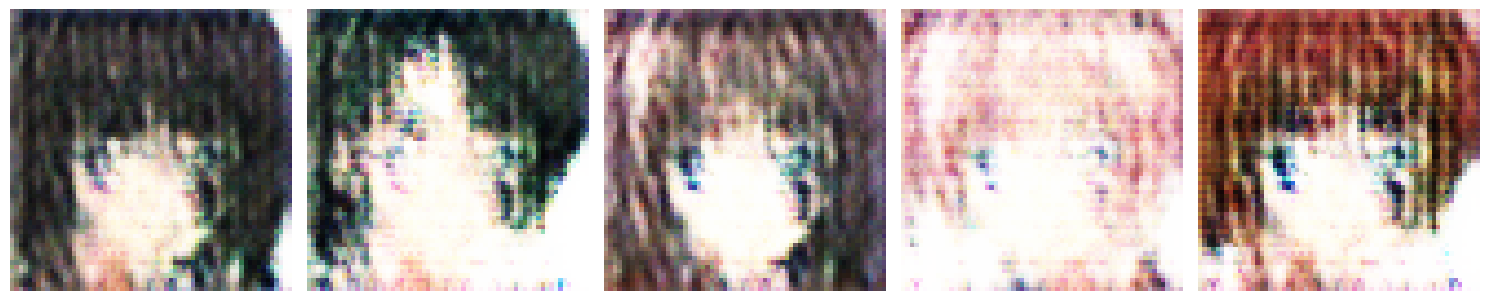

994/994 ━━━━━━━━━━━━━━━━━━━━ 60s 60ms/step - d_loss: 0.6397 - g_loss: 0.5904

[cls] [epoch: 2] - label real value: 0.9019999504089355 - label fake value: 0.09800000488758087
Epoch 2/15
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 0.6335 - g_loss: 0.5981

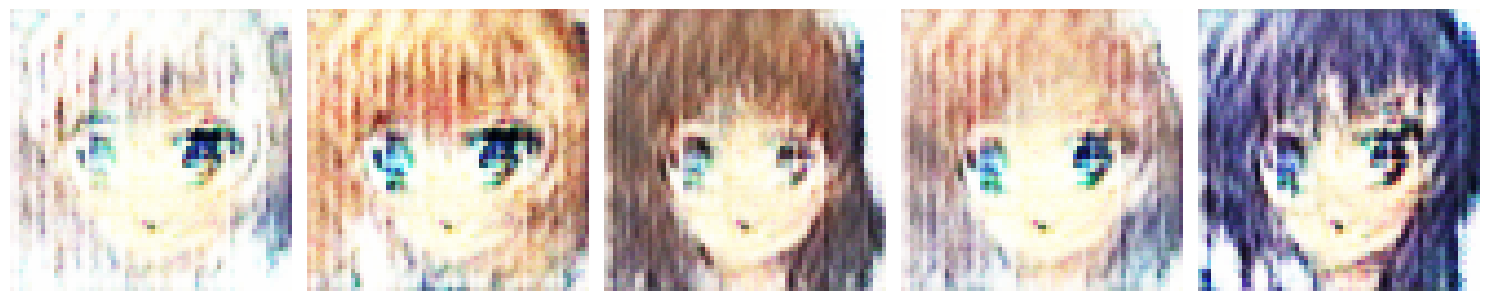

994/994 ━━━━━━━━━━━━━━━━━━━━ 61s 61ms/step - d_loss: 0.6335 - g_loss: 0.5981

[cls] [epoch: 3] - label real value: 0.902999997138977 - label fake value: 0.09700000286102295
Epoch 3/15
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 0.6391 - g_loss: 0.5760

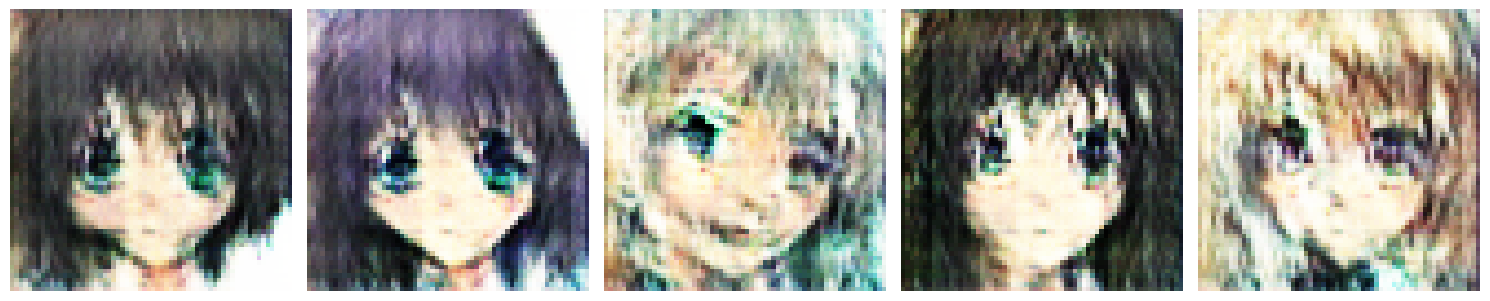

994/994 ━━━━━━━━━━━━━━━━━━━━ 82s 62ms/step - d_loss: 0.6391 - g_loss: 0.5760

[cls] [epoch: 4] - label real value: 0.9039999842643738 - label fake value: 0.09600000083446503
Epoch 4/15
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - d_loss: 0.6383 - g_loss: 0.5711

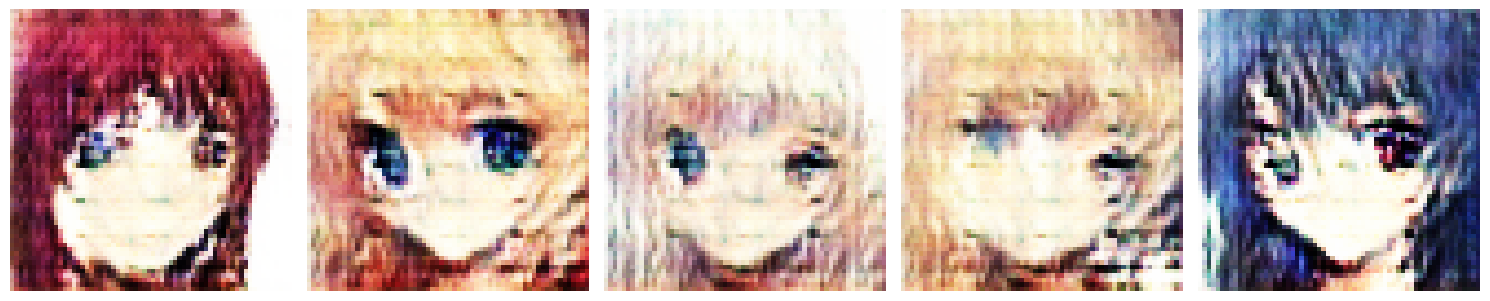

994/994 ━━━━━━━━━━━━━━━━━━━━ 62s 62ms/step - d_loss: 0.6383 - g_loss: 0.5711

[cls] [epoch: 5] - label real value: 0.9049999713897705 - label fake value: 0.0949999988079071
Epoch 5/15
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 0.6023 - g_loss: 0.6132

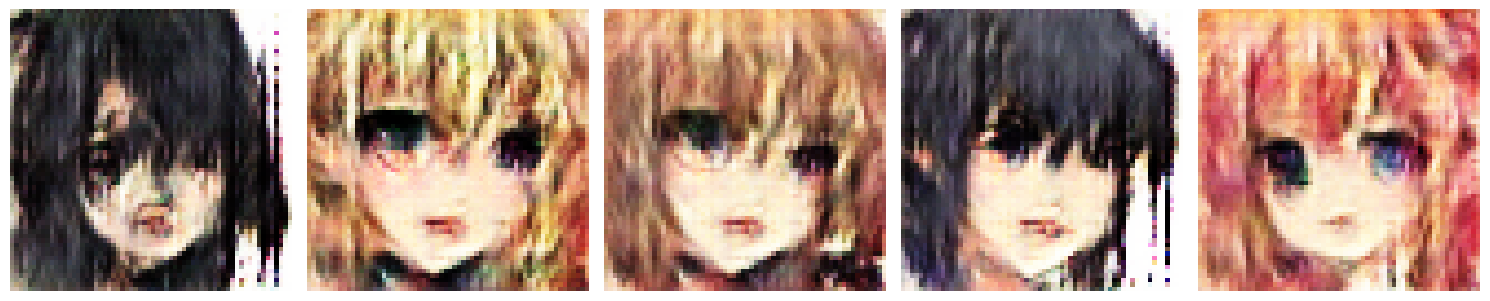

994/994 ━━━━━━━━━━━━━━━━━━━━ 61s 61ms/step - d_loss: 0.6023 - g_loss: 0.6132

[cls] [epoch: 6] - label real value: 0.9059999585151672 - label fake value: 0.09400000423192978
Epoch 6/15
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 0.5837 - g_loss: 0.6390

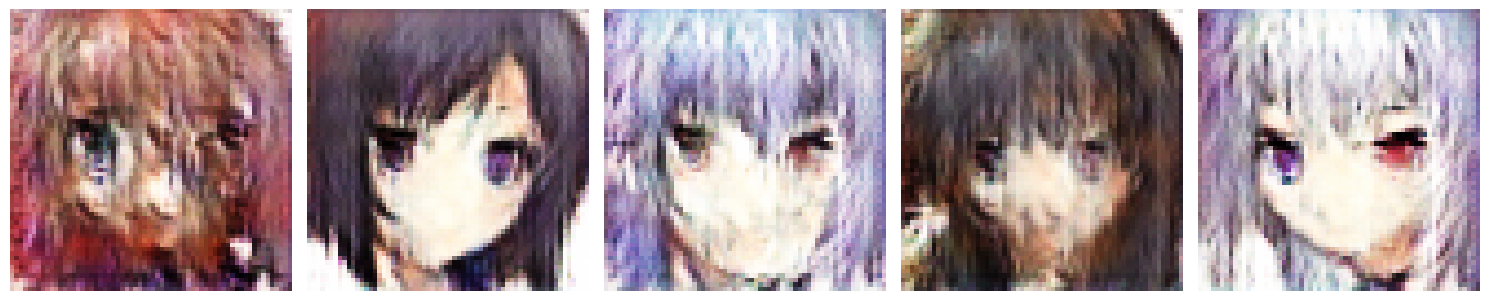

994/994 ━━━━━━━━━━━━━━━━━━━━ 61s 61ms/step - d_loss: 0.5837 - g_loss: 0.6390

[cls] [epoch: 7] - label real value: 0.9070000052452087 - label fake value: 0.09300000220537186
Epoch 7/15
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - d_loss: 0.5767 - g_loss: 0.6507

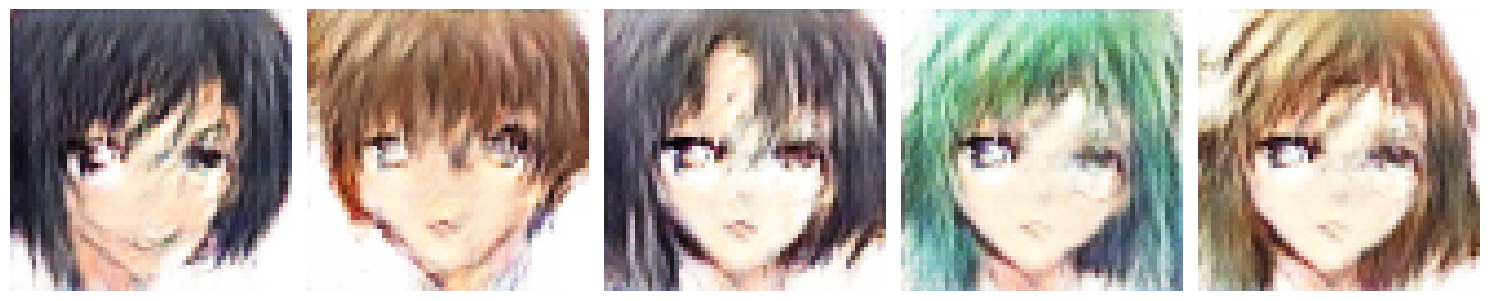

994/994 ━━━━━━━━━━━━━━━━━━━━ 82s 62ms/step - d_loss: 0.5767 - g_loss: 0.6507

[cls] [epoch: 8] - label real value: 0.9079999923706055 - label fake value: 0.09200000017881393
Epoch 8/15
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 0.5712 - g_loss: 0.6593

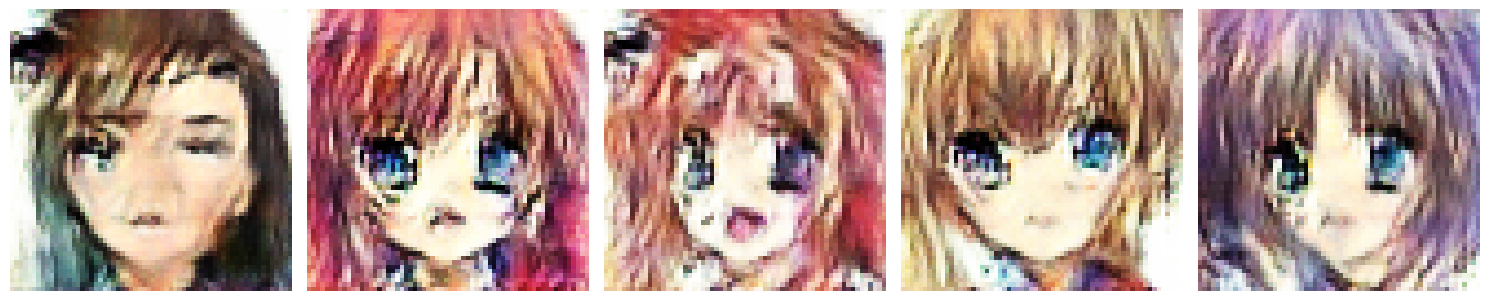

994/994 ━━━━━━━━━━━━━━━━━━━━ 61s 61ms/step - d_loss: 0.5712 - g_loss: 0.6593

[cls] [epoch: 9] - label real value: 0.9089999794960022 - label fake value: 0.09099999815225601
Epoch 9/15
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 0.5785 - g_loss: 0.6584

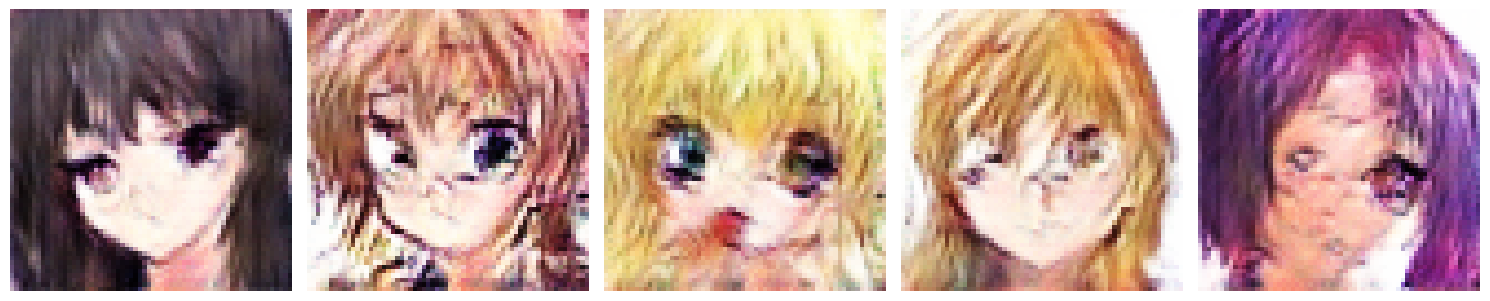

994/994 ━━━━━━━━━━━━━━━━━━━━ 61s 61ms/step - d_loss: 0.5785 - g_loss: 0.6584

[cls] [epoch: 10] - label real value: 0.9099999666213989 - label fake value: 0.09000000357627869
Epoch 10/15
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 0.5585 - g_loss: 0.6850
✓ Checkpoint saved: /content/drive/MyDrive/models/afgan/checkpoints/ckpt-1


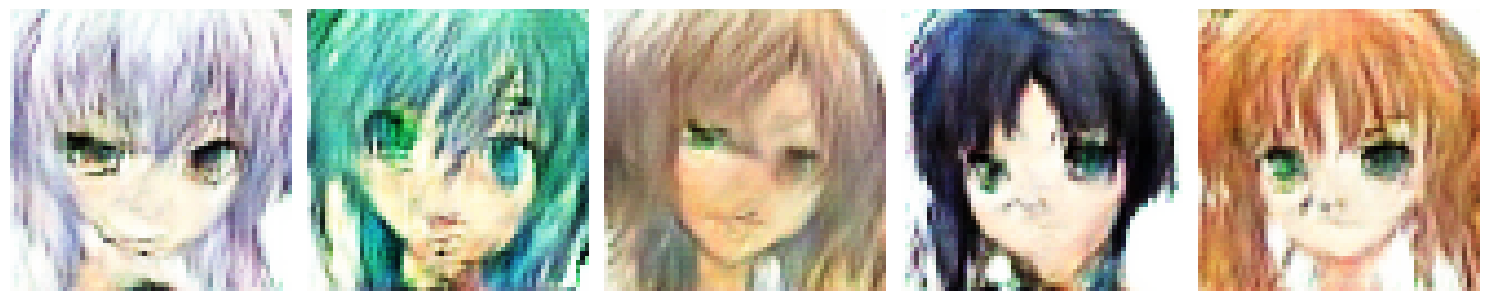

994/994 ━━━━━━━━━━━━━━━━━━━━ 61s 62ms/step - d_loss: 0.5585 - g_loss: 0.6850

[cls] [epoch: 11] - label real value: 0.9109999537467957 - label fake value: 0.08900000154972076
Epoch 11/15
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 0.5586 - g_loss: 0.6874

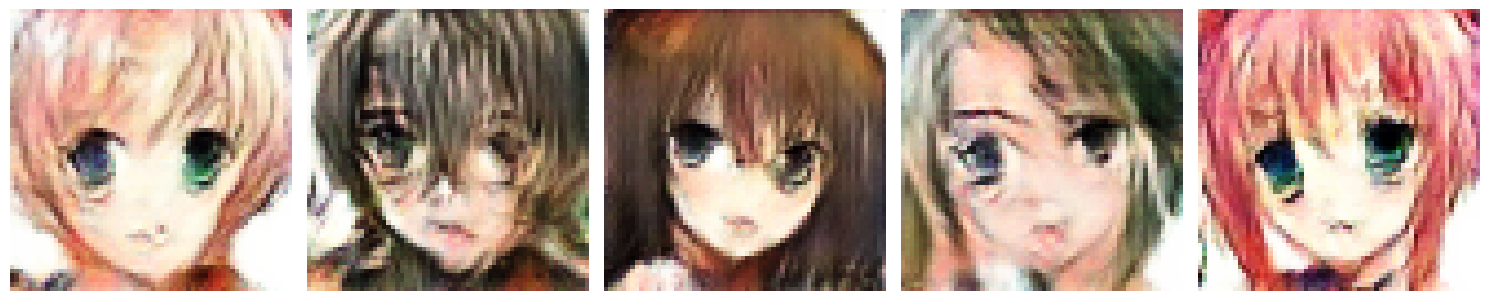

994/994 ━━━━━━━━━━━━━━━━━━━━ 61s 61ms/step - d_loss: 0.5586 - g_loss: 0.6874

[cls] [epoch: 12] - label real value: 0.9120000004768372 - label fake value: 0.08799999952316284
Epoch 12/15
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 0.5454 - g_loss: 0.7104

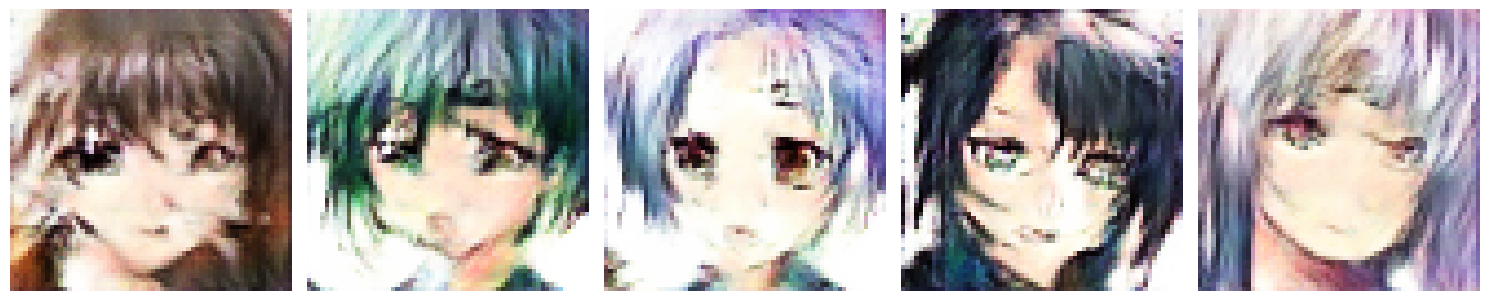

994/994 ━━━━━━━━━━━━━━━━━━━━ 61s 61ms/step - d_loss: 0.5454 - g_loss: 0.7104

[cls] [epoch: 13] - label real value: 0.9129999876022339 - label fake value: 0.08699999749660492
Epoch 13/15
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 0.5389 - g_loss: 0.7283

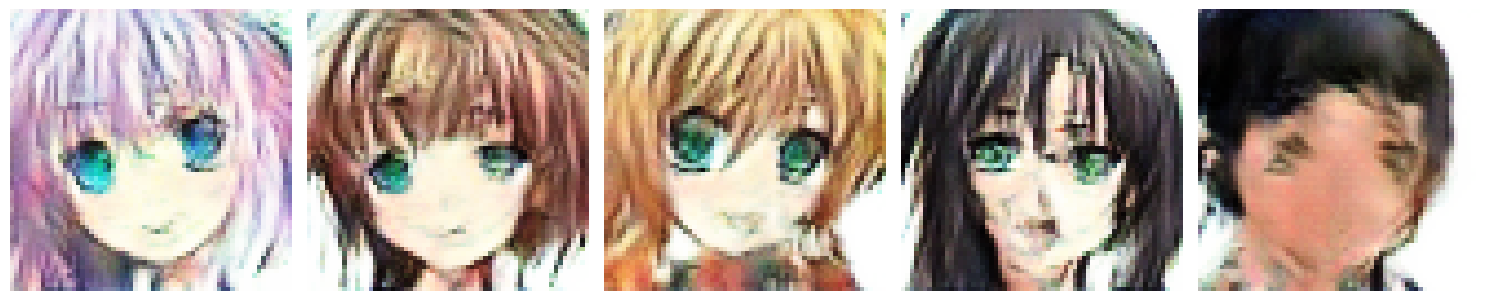

994/994 ━━━━━━━━━━━━━━━━━━━━ 61s 61ms/step - d_loss: 0.5388 - g_loss: 0.7283

[cls] [epoch: 14] - label real value: 0.9139999747276306 - label fake value: 0.0860000029206276
Epoch 14/15
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - d_loss: 0.5317 - g_loss: 0.7407

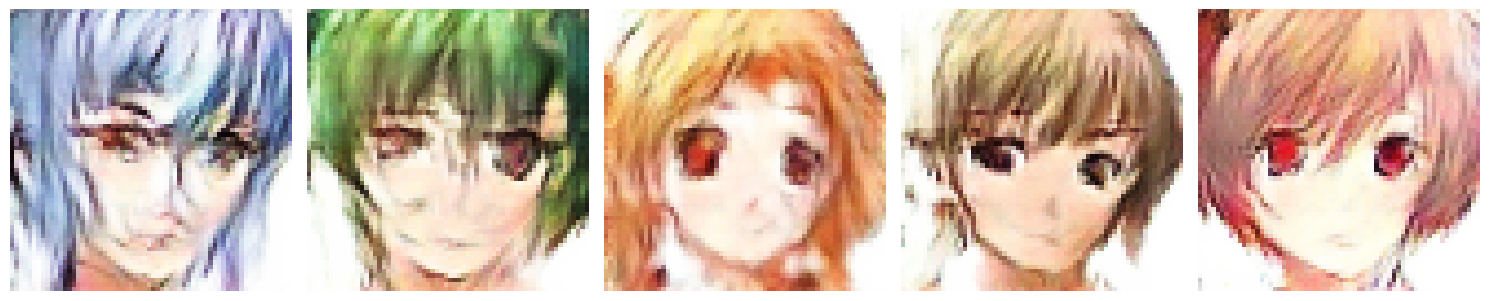

994/994 ━━━━━━━━━━━━━━━━━━━━ 61s 61ms/step - d_loss: 0.5318 - g_loss: 0.7407

[cls] [epoch: 15] - label real value: 0.9149999618530273 - label fake value: 0.08500000089406967
Epoch 15/15
993/994 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - d_loss: 0.5314 - g_loss: 0.7441
Epoch 15 - FID: 223.62


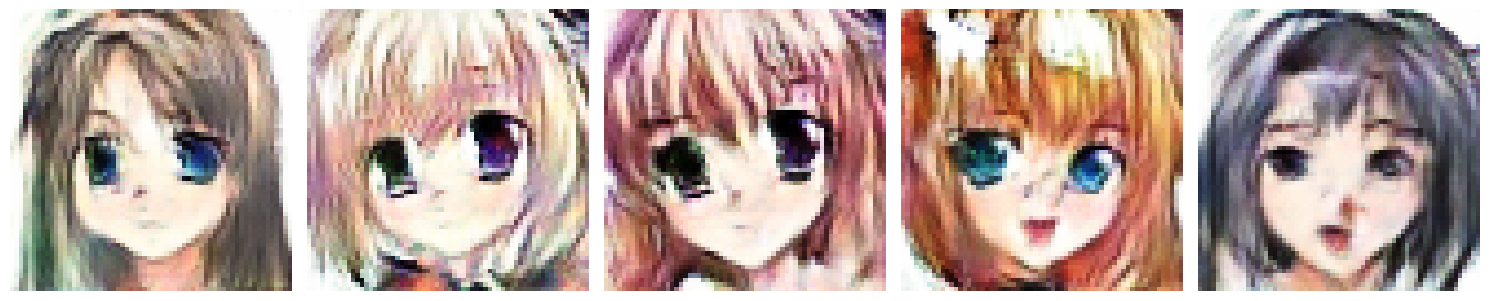

994/994 ━━━━━━━━━━━━━━━━━━━━ 121s 122ms/step - d_loss: 0.5314 - g_loss: 0.7441

✓ Final Checkpoint saved: /content/drive/MyDrive/models/afgan/checkpoints/ckpt-2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ Export finished
✓ GIF saved: generated/gifs/training_0.gif
✓ GIF saved: generated/gifs/training_1.gif
✓ GIF saved: generated/gifs/training_2.gif
✓ GIF saved: generated/gifs/training_3.gif
✓ GIF saved: generated/gifs/training_4.gif
✓ GIF saved: generated/gifs/training_combined.gif (15 frames)


In [126]:
gan.fit(
    train_dataset,
    epochs=MODEL_CONFIG['train']['epochs'],
    initial_epoch=MODEL_CONFIG['train']['initial_epoch'],
    callbacks=[
        ChangedLabelSmoothingCallback(),
        # NoiseAnnealingCallback(),
        fid_evaluate_callback,
        checkpoint_callback,
        export_callback,
        MonitorCallback(num_img=MODEL_CONFIG['train']['num_image_eval'], latent_dim=MODEL_CONFIG['latent_dim']),
    ]
)

### Metrics evolution

In [127]:
history = checkpoint_callback.get_history()

Show the evolution of losses

In [128]:
def show_loss_history(d_loss, g_loss):
    plt.figure(figsize=(10, 6))

    plt.plot(d_loss, label='Discriminator loss')
    plt.plot(g_loss, label='Generator loss')

    plt.title(f"{MODEL_CONFIG['model_name']} - Training Losses", fontweight='bold', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()

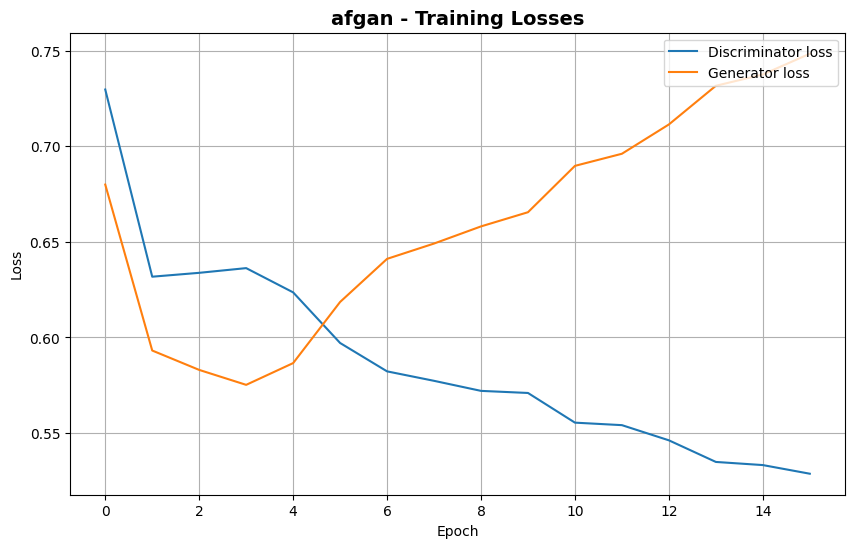

In [129]:
show_loss_history(history['d_loss'], history['g_loss'])

Show the evolution of the FID score

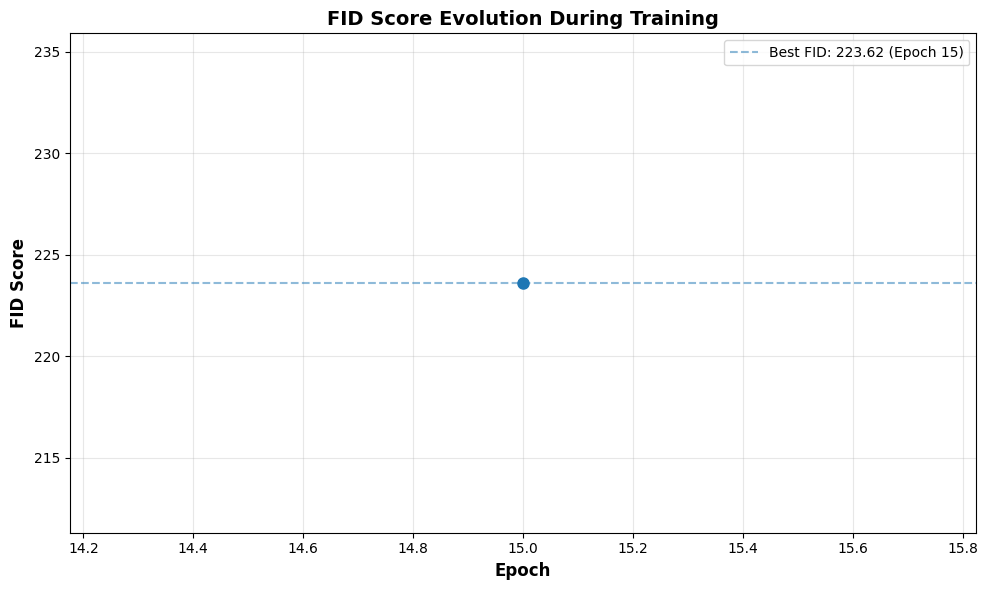

In [130]:
show_fid_history(history['fid_history'])

Show image generation evolution

In [131]:
def show_gifs(num_images=5, base_dir='generated'):
    gifs_dir = os.path.join(base_dir, 'gifs')

    html_content = '<div style="display: flex; flex-wrap: wrap; gap: 10px; justify-content: center;">'

    for i in range(num_images):
        gif_path = os.path.join(gifs_dir, f'training_{i}.gif')
        if os.path.exists(gif_path):
            with open(gif_path, 'rb') as f:
                gif_data = f.read()
                gif_base64 = base64.b64encode(gif_data).decode('utf-8')

            html_content += f'''
                <div style="text-align: center;">
                    <img src="data:image/gif;base64,{gif_base64}" style="width: 200px; border: 1px solid #ccc;">
                    <p style="font-weight: bold;">Image {i+1}</p>
                </div>
            '''

    html_content += '</div>'
    display(HTML(html_content))

In [132]:
show_gifs(num_images=MODEL_CONFIG['train']['num_image_eval'])

## Test

Util

In [133]:
def show_transformation(before, after, n_images=5, title=None, cols=5):
    def normalize_images(images):
        images = np.array(images)
        if images.min() < 0:
            images = (images + 1.0) / 2.0
        images = np.clip(images, 0, 1)
        return images

    before_normalized = normalize_images(before)
    after_normalized = normalize_images(after)

    rows_needed = ((n_images + cols - 1) // cols) * 2
    plt.figure(figsize=(3*cols, 3*rows_needed))

    if title:
        plt.suptitle(title, fontsize=16, fontweight='bold', y=0.99)

    for i in range(n_images):
        pair_row = (i // cols) * 2
        col = i % cols

        plt.subplot(rows_needed, cols, pair_row * cols + col + 1)
        plt.imshow(before_normalized[i])
        if i < cols:
            plt.title('Before', fontweight='bold', fontsize=10)
        plt.axis('off')

        plt.subplot(rows_needed, cols, (pair_row + 1) * cols + col + 1)
        plt.imshow(after_normalized[i])
        if i < cols:
            plt.title('After', fontweight='bold', fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [134]:
def generate_latent_vectors(latent_dim, n_samples=5):
  return np.random.normal(0, 1, size=(n_samples, latent_dim))

In [135]:
def transforme_latent_vectors_2_visualizations(z_vectors, target_size):
    z_visualizations = []

    for z in z_vectors:
        grid_size = int(np.ceil(np.sqrt(len(z))))

        z_padded = np.zeros(grid_size * grid_size)
        z_padded[:len(z)] = z
        z_matrix = z_padded.reshape(grid_size, grid_size)

        z_norm = (z_matrix - z_matrix.min()) / (z_matrix.max() - z_matrix.min() + 1e-8)

        zoom_factors = (target_size[0] / grid_size, target_size[1] / grid_size)
        z_vis = zoom(z_norm, zoom_factors, order=3)
        z_vis = np.clip(z_vis, 0, 1)

        z_vis = np.stack([z_vis, z_vis, z_vis], axis=2)

        z_visualizations.append(z_vis)

    return np.array(z_visualizations)

### Random Vector
Generated from a normal distribution

In [136]:
z_vectors = generate_latent_vectors(MODEL_CONFIG['latent_dim'], MODEL_CONFIG['test']['num_images'])

generated = generator.predict(z_vectors)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


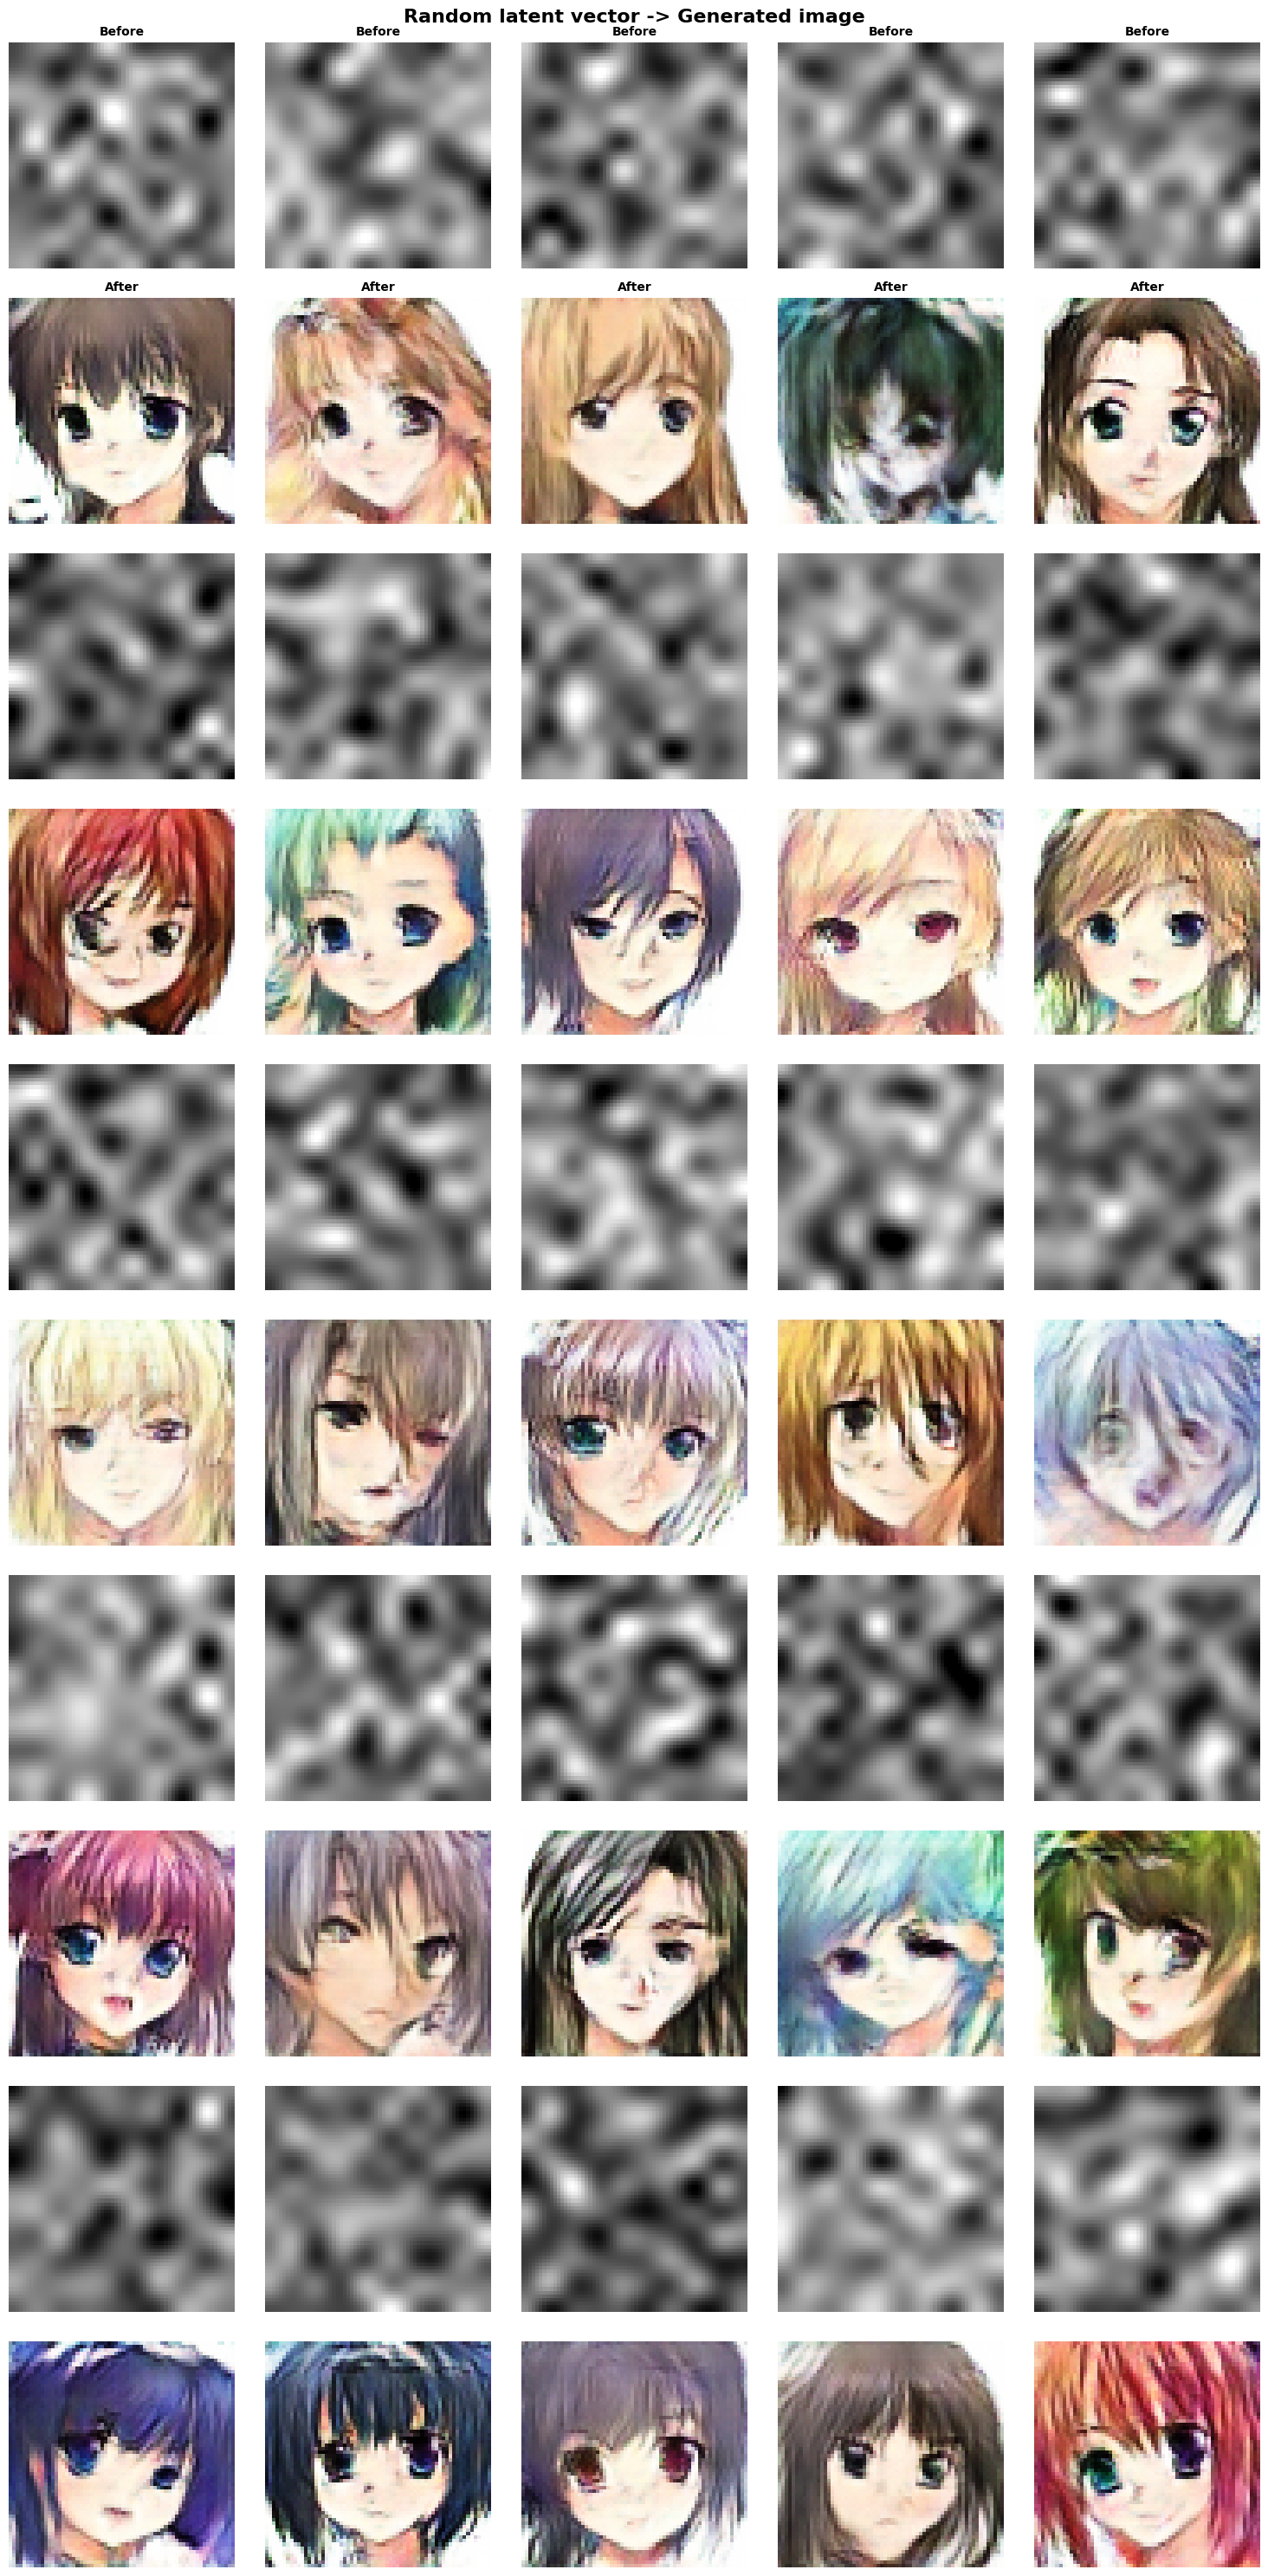

In [137]:
show_transformation(
    transforme_latent_vectors_2_visualizations(z_vectors, MODEL_CONFIG['image_size']),
    generated,
    MODEL_CONFIG['test']['num_images'],
    'Random latent vector -> Generated image'
)

## Result

In [138]:
def create_image_grid(images, grid_path, grid_size=(10, 10)):
    print(f"Creating image grid {grid_size[0]}x{grid_size[1]}...")

    rows, cols = grid_size
    num_images_in_grid = rows * cols

    images_normalized = ((images[:num_images_in_grid] + 1) / 2.0 * 255).astype(np.uint8)

    img_height, img_width = images_normalized.shape[1:3]

    grid_img = Image.new('RGB', (cols * img_width, rows * img_height))

    for idx in range(num_images_in_grid):
        row = idx // cols
        col = idx % cols

        img = Image.fromarray(images_normalized[idx])

        x = col * img_width
        y = row * img_height
        grid_img.paste(img, (x, y))

    grid_img.save(grid_path)

    print(f"✓ Grid saved at: {grid_path}")

    return grid_img


In [139]:
def create_result_grid_gif(images, output_path, duration=350):
    num_frames=5

    images_normalized = ((images + 1) / 2.0 * 255).astype(np.uint8)

    sample_img = Image.fromarray(images_normalized[0])
    img_size = sample_img.size

    step = len(images) // num_frames
    frames = []

    positions = [
        (0, 0), (2, 0),
        (1, 1),
        (0, 2), (2, 2)
    ]

    grid_width = img_size[0] * 3
    grid_height = img_size[1] * 3

    for frame_idx in range(num_frames):
        grid = Image.new('RGB', (grid_width, grid_height), color='black')

        for pos_idx, (col, row) in enumerate(positions):
            img_idx = frame_idx * step + pos_idx * (step // 5)
            if img_idx < len(images):
                img = Image.fromarray(images_normalized[img_idx])
                x = col * img_size[0]
                y = row * img_size[1]
                grid.paste(img, (x, y))

        frames.append(grid)

    if frames:
        frames[0].save(output_path, save_all=True, append_images=frames[1:], duration=duration, loop=0)

        print(f'✓ GIF saved: {output_path}')

Generate images

In [141]:
z_vectors = generate_latent_vectors(MODEL_CONFIG['latent_dim'], n_samples=MODEL_CONFIG['result']['num_images'])

generated_images = generator.predict(z_vectors, verbose=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step


Visualize generated images

Creating image grid 10x10...
✓ Grid saved at: /content/afgan-grid_1.png
Creating image grid 10x10...
✓ Grid saved at: /content/afgan-grid_2.png


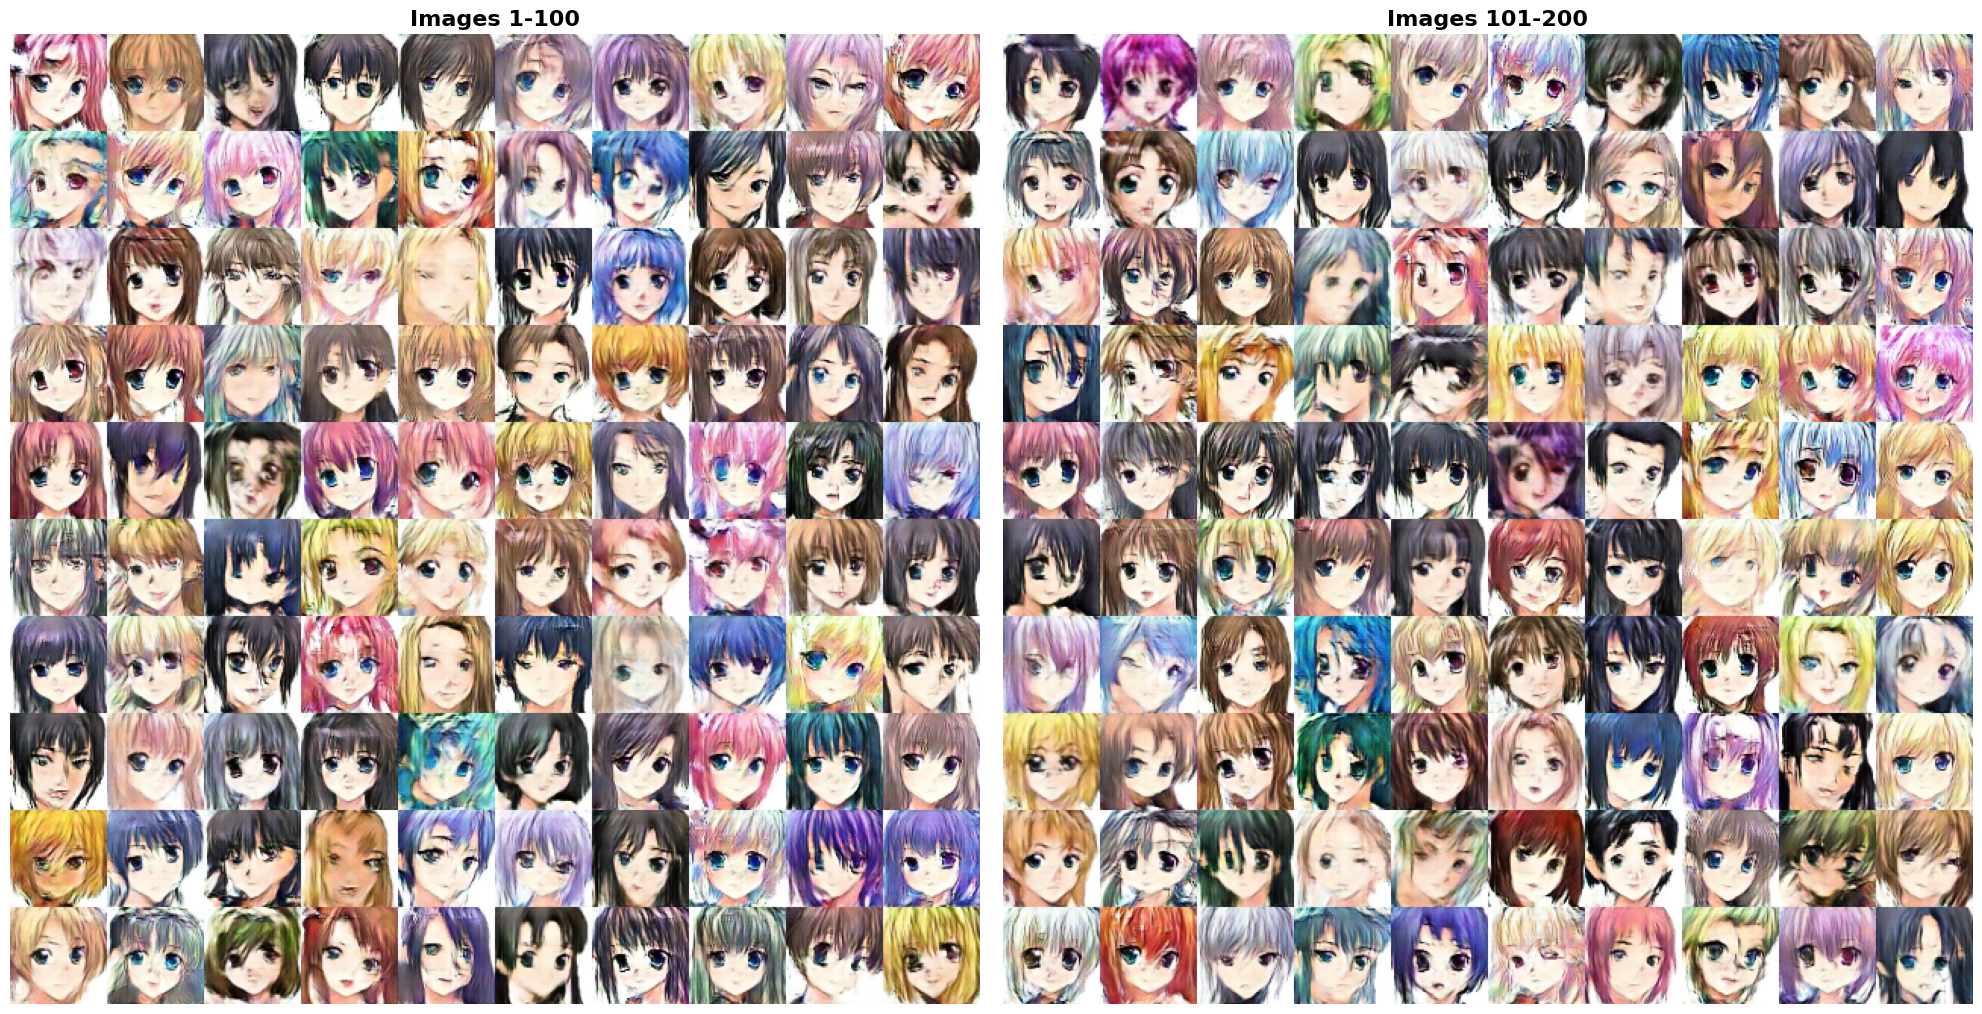

In [142]:
grid1_path = MODEL_CONFIG['result']['grid_path'].format(model_name=MODEL_CONFIG['model_name']).replace('.png', '_1.png')
grid1_img = create_image_grid(generated_images[0:100], grid1_path, grid_size=(10, 10))

grid2_path = MODEL_CONFIG['result']['grid_path'].format(model_name=MODEL_CONFIG['model_name']).replace('.png', '_2.png')
grid2_img = create_image_grid(generated_images[100:200], grid2_path, grid_size=(10, 10))

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(grid1_img)
axes[0].set_title('Images 1-100', fontsize=16, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(grid2_img)
axes[1].set_title('Images 101-200', fontsize=16, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

Crear gif

In [143]:
grid_gif_path = MODEL_CONFIG['result']['grid_gif_path'].format(model_name=MODEL_CONFIG['model_name'])
create_result_grid_gif(generated_images, grid_gif_path)

✓ GIF saved: /content/afgan-grid.gif


Descargar

In [144]:
print("Downloading files...")

files.download(grid1_path)
print(f"✓ Grid with images 1 downloaded")

files.download(grid2_path)
print(f"✓ Grid with images 2 downloaded")

files.download(grid_gif_path)
print(f"✓ Grid GIF downloaded")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Grid with images 1 downloaded


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Grid with images 2 downloaded


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Grid GIF downloaded


## Model evaluation

In [145]:
fid_scores = evaluate_gan_multiple_iterations(
    generator=generator,
    real_dataset=train_dataset,
    latent_dim=MODEL_CONFIG['latent_dim'],
    num_samples=MODEL_CONFIG['model_evaluation']['num_samples'],
    iterations=MODEL_CONFIG['model_evaluation']['iterations']
)

Model evaluate: 100%|██████████| 3/3 [01:55<00:00, 38.39s/it]


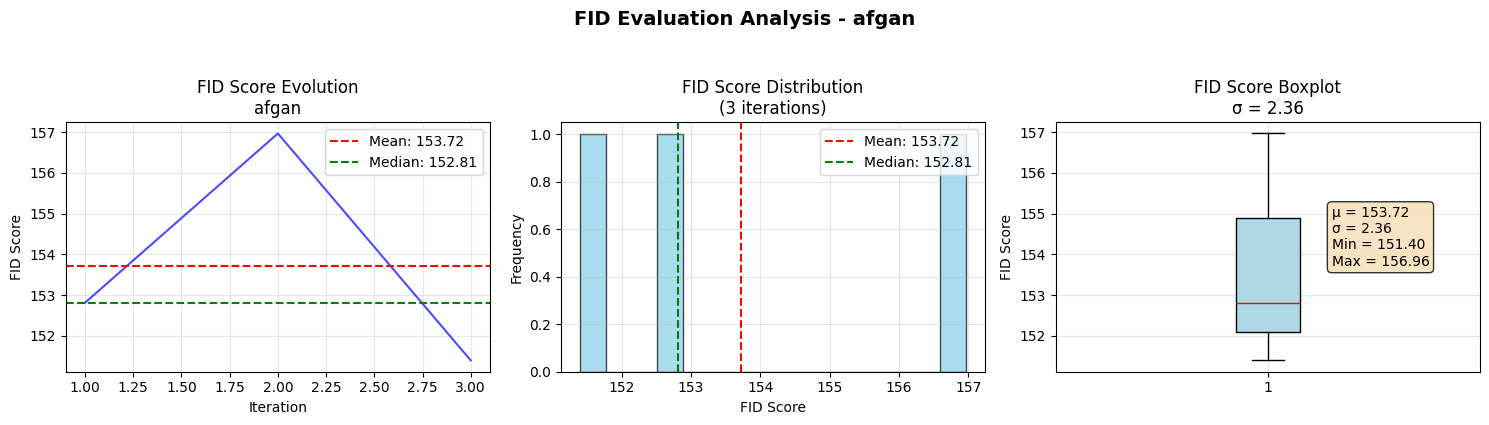

In [146]:
plot_evaluate_result(fid_scores)

# Other

## Visualizize model

Install dep. LaTeX

In [147]:
!apt-get update -qq
!apt-get install -y texlive-latex-base texlive-fonts-recommended texlive-fonts-extra texlive-latex-extra poppler-utils

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-adf-accanthis fonts-adf-berenis fonts-adf-gillius
  fonts-adf-universalis fonts-cabin fonts-cantarell fonts-comfortaa
  fonts-croscore fonts-crosextra-caladea fonts-crosextra-carlito
  fonts-dejavu-core fonts-dejavu-extra fonts-droid-fallback fonts-ebgaramond
  fonts-ebgaramond-extra fonts-font-awesome fonts-freefont-otf
  fonts-freefont-ttf fonts-gfs-artemisia fonts-gfs-complutum fonts-gfs-didot
  fonts-gfs-neohellenic fonts-gfs-olga fonts-gfs-solomos fonts-go
  fonts-junicode fonts-lato fonts-linuxlibertine fonts-lmodern fonts-lobster
  fonts-lobstertwo fonts-noto-color-emoji fonts-noto-core fonts-noto-mono
  fonts-oflb-asana-math font

Clon lib

In [148]:
!rm -rf PlotNeuralNet
!git clone https://github.com/HarisIqbal88/PlotNeuralNet.git

Cloning into 'PlotNeuralNet'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 300 (delta 81), reused 72 (delta 72), pack-reused 194 (from 1)
Receiving objects: 100% (300/300), 2.28 MiB | 2.58 MiB/s, done.
Resolving deltas: 100% (136/136), done.


Import

In [149]:
import sys
sys.path.append('./PlotNeuralNet/')
from PlotNeuralNet.pycore.tikzeng import *
from PlotNeuralNet.pycore.blocks import *

import math
import os
from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt

/content/PlotNeuralNet/pycore/tikzeng.py:40: SyntaxWarning: invalid escape sequence '\i'
  \node[canvas is zy plane at x=0] (""" + name + """) at """+ to +""" {\includegraphics[width="""+ str(width)+"cm"+""",height="""+ str(height)+"cm"+"""]{"""+ pathfile +"""}};
/content/PlotNeuralNet/pycore/tikzeng.py:52: SyntaxWarning: invalid escape sequence '\C'
  fill=\ConvColor,
/content/PlotNeuralNet/pycore/tikzeng.py:70: SyntaxWarning: invalid escape sequence '\C'
  fill=\ConvColor,
/content/PlotNeuralNet/pycore/tikzeng.py:142: SyntaxWarning: invalid escape sequence '\S'
  fill=\SoftmaxColor,
/content/PlotNeuralNet/pycore/tikzeng.py:159: SyntaxWarning: invalid escape sequence '\S'
  fill=\SoftmaxColor,
/content/PlotNeuralNet/pycore/tikzeng.py:173: SyntaxWarning: invalid escape sequence '\S'
  fill=\SumColor,
/content/PlotNeuralNet/pycore/tikzeng.py:184: SyntaxWarning: invalid escape sequence '\m'
  \draw [connection]  ("""+of+"""-east)    -- node {\midarrow} ("""+to+"""-west);
/content/PlotNeu

Arch

In [150]:
def to_ConvTranspose(name, s_filer=1, n_filer=1, offset="(0,0,0)", to="(0,0,0)",
                     width=1, height=1, depth=1, caption=" "):
    """
    Crea un bloque de Conv2DTranspose con color azul
    """
    return r"""
\pic[shift={"""+ offset +"""}] at """+ to +"""
    {Box={
        name=""" + name + """,
        caption="""+ caption +r""",
        xlabel={{ """+ str(n_filer) +""" }},
        zlabel="""+ str(s_filer) +r""",
        fill={rgb:blue,5;white,5},
        height="""+ str(height) +""",
        width="""+ str(width) +""",
        depth="""+ str(depth) +"""
        }
    };
"""

In [151]:
def generate_gan_arch():
    arch = [
        to_head('..'),
        to_cor(),
        to_begin(),
    ]

    # ============= GENERATOR =============
    # Input latent vector (flattened)
    arch.extend([
        to_SoftMax("latent", s_filer=100, offset="(0,0,0)", to="(0,0,0)",
                  width=2, height=25, depth=1,
                  caption="Input\\\\Latent\\\\100")
    ])

    # Dense layer: 100 -> 8192
    arch.extend([
        to_SoftMax("gen_dense", s_filer=32, offset="(2.5,0,0)",
                  to="(latent-east)", width=4, height=32, depth=4,
                  caption="Dense\\\\8192\\\\ReLU"),
        to_connection("latent", "gen_dense")
    ])

    # Reshape: 8192 -> 4x4x512
    arch.extend([
        to_Conv("gen_reshape", s_filer=4, n_filer=512, offset="(2.5,0,0)",
               to="(gen_dense-east)", height=4, depth=4, width=10,
               caption="Reshape\\\\4x4x512"),
        to_connection("gen_dense", "gen_reshape")
    ])

    # Generator Conv2DTranspose layers
    generator_layers = [
        {'size': 8, 'filters': 256, 'caption': 'ConvT(4x4)\\\\8x8x256\\\\BN\\\\ReLU'},
        {'size': 16, 'filters': 128, 'caption': 'ConvT(4x4)\\\\16x16x128\\\\BN\\\\ReLU'},
        {'size': 32, 'filters': 64, 'caption': 'ConvT(4x4)\\\\32x32x64\\\\BN\\\\ReLU'},
        {'size': 64, 'filters': 32, 'caption': 'ConvT(4x4)\\\\64x64x32\\\\BN\\\\ReLU'},
    ]

    prev = "gen_reshape"
    for i, layer in enumerate(generator_layers, 1):
        name = f"gen_convt{i}"
        width = 2 + layer['filters'] // 32

        arch.extend([
            to_ConvTranspose(name, s_filer=layer['size'], n_filer=layer['filters'],
                   offset="(2.5,0,0)", to=f"({prev}-east)",
                   height=layer['size'], depth=layer['size'], width=width,
                   caption=layer['caption']),
            to_connection(prev, name)
        ])

        # Add dashed lines to indicate upsampling
        arch.append(
            f"\\draw[densely dashed] ({prev}-nearnortheast)--({name}-nearnorthwest) "
            f"({prev}-nearsoutheast)--({name}-nearsouthwest) "
            f"({prev}-farsoutheast)--({name}-farsouthwest) "
            f"({prev}-farnortheast)--({name}-farnorthwest);\n"
        )

        prev = name

    # Output Generator: 64x64x3
    arch.extend([
        to_ConvTranspose("gen_output", s_filer=64, n_filer=3, offset="(2.5,0,0)",
               to=f"({prev}-east)", height=64, depth=64, width=1,
               caption="ConvT(3x3)\\\\64x64x3\\\\tanh"),
        to_connection(prev, "gen_output")
    ])

    # Dashed lines for the final generator layer
    arch.append(
        f"\\draw[densely dashed] ({prev}-nearnortheast)--(gen_output-nearnorthwest) "
        f"({prev}-nearsoutheast)--(gen_output-nearsouthwest) "
        f"({prev}-farsoutheast)--(gen_output-farsouthwest) "
        f"({prev}-farnortheast)--(gen_output-farnorthwest);\n"
    )

    # ============= DISCRIMINATOR =============
    # Input real/fake image
    arch.extend([
        to_Conv("disc_input", s_filer=64, n_filer=3, offset="(5,0,0)",
               to="(gen_output-east)", height=64, depth=64, width=1,
               caption="Input\\\\64x64x3"),
        to_connection("gen_output", "disc_input")
    ])

    # Data augmentation + regularization
    arch.extend([
        to_Conv("augment", s_filer=64, n_filer=3, offset="(1.5,0,0)",
               to="(disc_input-east)", height=64, depth=64, width=1,
               caption="DataAug\\\\+\\\\Regularization"),
        to_connection("disc_input", "augment")
    ])

    # Discriminator Conv2D layers
    discriminator_layers = [
        {'size': 32, 'filters': 32, 'caption': 'Conv2D(4x4)\\\\32x32x32\\\\LeakyReLU\\\\Dropout'},
        {'size': 16, 'filters': 64, 'caption': 'Conv2D(4x4)\\\\16x16x64\\\\BN\\\\LeakyReLU\\\\Dropout'},
        {'size': 8, 'filters': 128, 'caption': 'Conv2D(4x4)\\\\8x8x128\\\\BN\\\\LeakyReLU\\\\Dropout'},
        {'size': 4, 'filters': 256, 'caption': 'Conv2D(4x4)\\\\4x4x256\\\\BN\\\\LeakyReLU\\\\Dropout'},
        {'size': 4, 'filters': 512, 'caption': 'Conv2D(3x3)\\\\4x4x512\\\\BN\\\\LeakyReLU\\\\Dropout'},
    ]

    prev = "augment"
    for i, layer in enumerate(discriminator_layers, 1):
        name = f"disc_conv{i}"
        width = 2 + layer['filters'] // 64

        arch.extend([
            to_Conv(name, s_filer=layer['size'], n_filer=layer['filters'],
                   offset="(2.5,0,0)", to=f"({prev}-east)",
                   height=layer['size'], depth=layer['size'], width=width,
                   caption=layer['caption']),
            to_connection(prev, name)
        ])
        prev = name

    # Flatten layer
    arch.extend([
        to_SoftMax("flatten", s_filer=32, offset="(2.0,0,0)",
                  to=f"({prev}-east)", width=2, height=32, depth=1,
                  caption="Flatten\\\\8192"),
        to_connection(prev, "flatten")
    ])

    # Output discriminator
    arch.extend([
        to_SoftMax("disc_output", s_filer=8, offset="(2.5,0,0)",
                  to="(flatten-east)", width=3, height=8, depth=3,
                  caption="Dense\\\\1\\\\Sigmoid\\\\Real/Fake"),
        to_connection("flatten", "disc_output"),
        to_end()
    ])

    return arch

In [152]:
def visualize_gan(filename='gan_arch', dpi=300):
    import subprocess

    arch = generate_gan_arch()

    original_dir = os.getcwd()
    target_dir = 'PlotNeuralNet/pyexamples/'

    os.chdir(target_dir)

    # Generate .tex file
    with open(f'{filename}.tex', 'w') as f:
        for line in arch:
            f.write(line)

    # Compile LaTeX
    print(f"Compiling {MODEL_CONFIG['model_name']} architecture...")
    result = subprocess.run(
        ['pdflatex', '-interaction=nonstopmode', f'{filename}.tex'],
        capture_output=True,
        text=True
    )

    # Check compilation
    if 'Output written on' not in result.stdout:
        print("❌ LaTeX compilation error")
        print(result.stdout[-500:])
        os.chdir(original_dir)
        return

    # Convert PDF to PNG
    subprocess.run(
        ['pdftoppm', '-png', '-r', str(dpi), '-singlefile', f'{filename}.pdf', filename],
        capture_output=True
    )

    os.chdir(original_dir)

    # Copy and display
    source_png = f'{target_dir}{filename}.png'
    if os.path.exists(source_png):
        os.system(f'cp {source_png} ./{filename}.png')

        img = Image.open(f'{filename}.png')
        plt.figure(figsize=(20, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'{MODEL_CONFIG['model_name']} Architecture', fontsize=18, fontweight='bold')
        plt.tight_layout()
        plt.show()

        files.download(f'{filename}.png')
    else:
        print(f"❌ Error: {filename}.png was not generated")

Compiling afgan architecture...


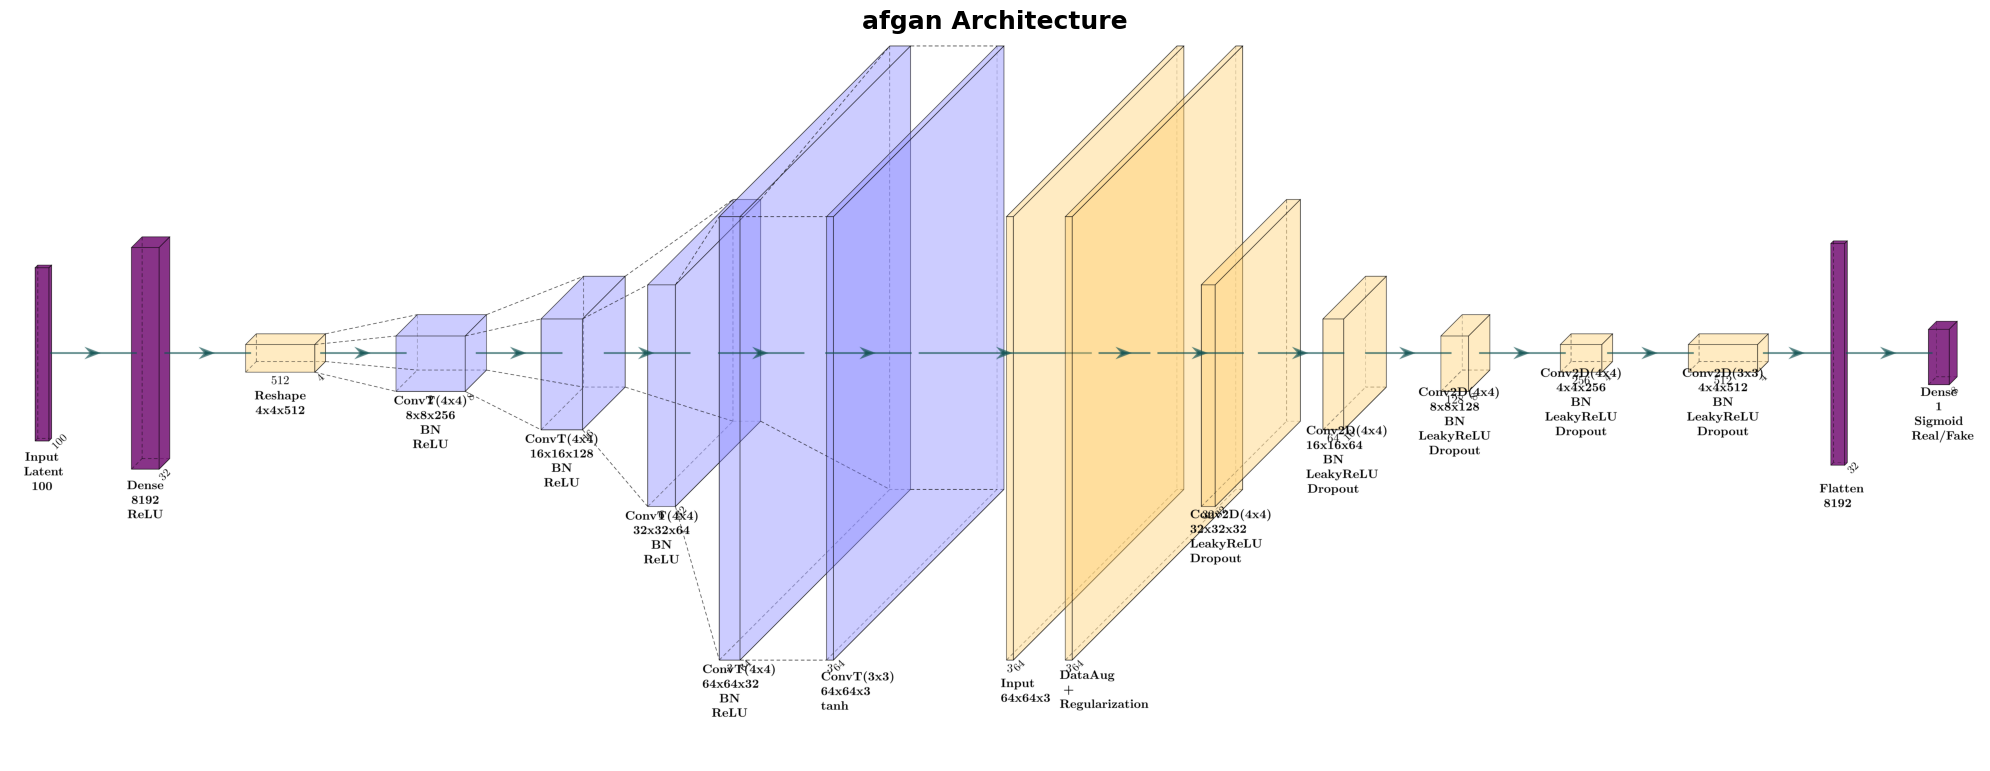

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [153]:
visualize_gan()